In [9]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_setup.ipynb

# Hypothesis 2.3

If there are data quality differences between datasets, then the dataset identity will predict quality metrics.

## Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [3]:
#project directory
project_dir = Path('/data/NNDSP')
# NNDSP data directories
nndsp_project_dir = Path('/data/NNDSP')
nndsp_bids_dir = nndsp_project_dir.joinpath('bids_2017_07_14_generic')
nndsp_fs_dir = nndsp_project_dir.joinpath('derivatives/fs5.3_subj')
nndsp_bar_dir = nndsp_project_dir.joinpath('derivatives/bar_subj')
nndsp_mriqc_dir = nndsp_project_dir.joinpath('derivatives/mriqc_2018_06_08')
nndsp_pheno_file = nndsp_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_project_dir = Path('/data/HCP_preproc')
hcp_bids_dir = hcp_project_dir.joinpath('bids_hcp_1200')
hcp_fs_dir = nndsp_project_dir.joinpath('derivatives/fs_hcp_subj')
hcp_bar_dir = nndsp_project_dir.joinpath('derivatives/bar_hcp_subj')
hcp_mriqc_dir = hcp_project_dir.joinpath('mriqc_hcp_2018_07_22')
hcp_pheno_file = nndsp_project_dir.joinpath('nino/HCP_ages.csv')
hcp_pheno2_file = nndsp_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/hcp_unrestricted.csv')

# NKI data directories
nki_project_dir = nndsp_project_dir
nki_bids_dir = nki_project_dir.joinpath('anal/NKI')
nki_fs_dir = nki_project_dir.joinpath('derivatives/fs_nki_subj')
nki_bar_dir = nki_project_dir.joinpath('derivatives/bar_nki_subj')
nki_mriqc_dir = nki_project_dir.joinpath('derivatives/mriqc_nki_2018_07_16')
nki_pheno_file = nki_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_project_dir = Path('/data/DSST/CoRR')
corr_bids_dir = corr_project_dir.joinpath('bids_corr')
corr_fs_dir = corr_project_dir.joinpath('derivatives/fs_corr')
corr_bar_dir = corr_project_dir.joinpath('derivatives/bar_corr/baracus')
corr_mriqc_dir = corr_project_dir.joinpath('derivatives/mriqc_corr')
corr_pheno_file = corr_project_dir.joinpath('phenotype_files/corr_ages.csv')

# SALD data directories
sald_project_dir = Path('/data/DSST/SALD')
sald_bids_dir = sald_project_dir.joinpath('bids_sald')
sald_fs_dir = sald_project_dir.joinpath('derivatives/fs_sald')
sald_bar_dir = sald_project_dir.joinpath('derivatives/bar_sald/baracus')
sald_mriqc_dir = sald_project_dir.joinpath('derivatives/mriqc_sald')
sald_pheno_file = sald_project_dir.joinpath('phenotype_files/sub_information.xlsx')

## Load MRIQC Json Files

In [4]:
import json
import re

In [10]:
df_nndsp = mriqc_df(nndsp_mriqc_dir, nndsp_pheno_file, data='NNDSP', data_class = 3, 
                    merge_df = (nndsp_subjectdata(nndsp_fs_dir, nndsp_pheno_file)[['subject', 'sex']]))
df_hcp = mriqc_df(hcp_mriqc_dir, hcp_pheno_file, data='HCP', data_class = 4, 
                 merge_df = (hcp_subjectdata(hcp_fs_dir, hcp_pheno_file, hcp_pheno2_file)[['subject', 'sex']]))
df_nki = mriqc_df(nki_mriqc_dir, nki_pheno_file, data='NKI', data_class = 5,
                 merge_df = (nki_subjectdata(nki_fs_dir, nki_pheno_file)[['subject', 'sex']]))
df_corr = mriqc_df(corr_mriqc_dir, corr_pheno_file, data='CoRR', data_class = 6, 
                  merge_df = (corr_subjectdata(corr_fs_dir, corr_pheno_file)[['subject','sex']]))
df_sald = mriqc_df(sald_mriqc_dir, sald_pheno_file, data='SALD', data_class = 7,
                  merge_df = (sald_subjectdata(sald_fs_dir, sald_pheno_file)[['subject', 'sex']]))

True
True


In [11]:
df_all = pd.concat([df_nndsp, df_hcp, df_nki, df_corr, df_sald], axis=0, join='outer', sort=False)
df_all.head()

subject session_id  acq_id  run_id       cjv       cnr       efc  \
0     102          1     0.0     1.0  0.450745  2.966345  0.731650   
1     114          1     0.0     1.0  0.597186  2.285747  0.738215   
2     126          1     0.0     1.0  0.325163  4.105503  0.715936   
3     127          1     0.0     1.0  0.331401  4.022244  0.731355   
4     133          1     0.0     1.0  0.374933  3.617528  0.634474   

           fber  fwhm_avg    fwhm_x ...   summary_wm_p05  summary_wm_p95  \
0  26904.433594  3.339224  3.681080 ...       921.248688     1081.648413   
1  25883.199219  3.400049  3.794461 ...       924.199457     1084.025879   
2  22670.064453  3.143957  3.302560 ...       906.751019     1096.440839   
3  30989.095703  3.051045  3.257622 ...       908.286295     1095.220068   
4   8574.626953  3.196221  3.525169 ...       927.353989     1068.836938   

   summary_wm_stdv  tpm_overlap_csf  tpm_overlap_gm  tpm_overlap_wm    wm2max  \
0        49.010384         0.222196        0.505360        0.562915  0.424826   
1        49.015297         0.213160        0.493546        0.555361  0.398110   
2        57.998871         0.202775        0.545467        0.515358  0.378795   
3        57.538391         0.199213        0.536563        0.520068  0.380536   
4        43.263741         0.192762        0.516845        0.550855  0.458206   

   dataset  data_class  sex  
0    NNDSP           3    2  
1    NNDSP           3    2  
2    NNDSP           3    2  
3    NNDSP           3    2  
4    NNDSP           3    1  

[5 rows x 75 columns]

In [12]:
len(df_all)

6370

In [13]:
dataset_mapping = {
    '3' : 'nndsp',
    '4' : 'hcp',
    '5' : 'nki',
    '6' : 'corr',
    '7' : 'sald'
}

In [14]:
sex_mapping = {
    '1' : 'female',
    '2' : 'male'
}

## Linear Models

In [15]:
qc_metrics = ['cjv', 'cnr','efc', 'fber',
       'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm',
       'icvs_wm', 'inu_med', 'inu_range', 'qi_1', 'qi_2', 'rpve_csf',
       'rpve_gm', 'rpve_wm', 'size_x', 'size_y',
       'size_z', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf',
       'snrd_gm', 'snrd_total', 'snrd_wm', 'spacing_x', 'spacing_y',
       'spacing_z', 'summary_bg_k', 'summary_bg_mad',
       'summary_bg_mean', 'summary_bg_median', 'summary_bg_n',
       'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_csf_k',
       'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median',
       'summary_csf_n', 'summary_csf_p05', 'summary_csf_p95',
       'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean',
       'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95',
       'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean',
       'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95',
       'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm',
       'tpm_overlap_wm', 'wm2max']

### Model

In [16]:
from sklearn import linear_model
from scipy.stats import f

p_vals = []
metrics = []
for qc_metric in qc_metrics:
    print(qc_metric)
    df_qc = pd.DataFrame([])
    df_qc[qc_metric] = df_all[[qc_metric, 'data_class', 'sex']].dropna()[qc_metric]
    df_qc['sex'] = df_all[[qc_metric, 'data_class', 'sex']].dropna()['sex']
    df_qc['dataset'] = df_all[[qc_metric, 'data_class', 'sex']].dropna()['data_class']
        
    for c in df_all.data_class.drop_duplicates():
        df_qc[dataset_mapping[str(c)]] = [1 if c == df_qc.dataset.values[x] else 0 for x in range(0,len(df_qc))]
    for s in df_qc.sex.drop_duplicates():
        df_qc[sex_mapping[str(s)]] = [1 if s == df_qc.sex.values[x] else 0 for x in range(0,len(df_qc))]
        
    y = df_qc[qc_metric]
    X = df_qc[['male', 'female', 'nndsp', 'hcp', 'nki', 'corr', 'sald']]
        
    lm_full = linear_model.LinearRegression().fit(X,y)
    rss_f = np.mean((lm_full.predict(X) - y) ** 2)
    
    lm_res = linear_model.LinearRegression().fit(df_qc[['male', 'female']], y)
    rss_r = np.mean((lm_res.predict(df_qc[['male', 'female']]) - y) ** 2)
    
    df_f = (len(df_qc) - 1) - (X.shape[1] - 1)
    df_r = (len(df_qc) - 1) - (df_qc[['male', 'female']].shape[1] - 1)
    
    F = ((rss_r - rss_f)/(df_r - df_f))/(rss_f/df_f)
    p_val = f.sf(F, df_r - df_f, df_f)
        
    print(rss_f, rss_r)
    print(lm_full.coef_, lm_res.coef_)
    print(F)
    print(p_val)
    print(f.ppf(q=1-0.1, dfn=(df_r-df_f), dfd=df_f))
    print("")
    
    if p_val <= 0.1:
        p_vals.append(p_val)
        metrics.append(qc_metric)

cjv
0.0064119496317838285 0.017032464230713154
[ 0.00336331 -0.00336331 -0.0424374   0.17059    -0.06369036 -0.08391171
  0.01944948] [-0.00050076  0.00050076]
2107.887250330342
0.0
1.8481768443832496

cnr
0.3069675523660917 0.6027983284891371
[-0.03818663  0.03818663  0.22062895 -0.84013456  0.30833973  0.51796699
 -0.20680111] [-0.01562732  0.01562732]
1226.4300991826055
0.0
1.8481768443832496

efc
0.0018161147891862497 0.0029015518850372592
[ 0.01198382 -0.01198382  0.00578032 -0.04827877 -0.02856019  0.02681715
  0.04424149] [ 0.01370066 -0.01370066]
760.5946806913724
0.0
1.8481768443832496

fber
136078348.15500298 208561985.05365464
[   52.90985732   -52.90985732 21544.0009804  -8895.3910575
  2686.01823553 -8220.05694767 -7114.57121076] [ 272.06455456 -272.06455456]
677.8644624062683
0.0
1.8481768443832496

fwhm_avg
0.17066495905880452 0.45033214915048037
[ 0.04841086 -0.04841086 -0.71346435  0.96872215  0.04808659 -0.25165077
 -0.05169362] [ 0.01793149 -0.01793149]
2085.39859660

95.11873304347557 106.57665146353624
[ 0.39335178 -0.39335178  0.51176483  1.19188114 -4.23713056  4.73848745
 -2.20500286] [ 0.59988274 -0.59988274]
153.2962699861084
3.3574733610816475e-154
1.8481768443832496

summary_csf_k
554.5541585992547 564.2067416473225
[ 0.11352048 -0.11352048  7.18292936  1.52626669 -4.29267611  1.56757618
 -5.98409612] [ 0.35737755 -0.35737755]
22.150906266754543
4.456058201130784e-22
1.8481768443832496

summary_csf_mad
1298.3786355455486 1505.8599779482633
[ -0.04477949   0.04477949  43.4516883   -7.08851973 -15.94005876
  -1.55643929 -18.86667053] [ 1.07590279 -1.07590279]
203.3619077771955
1.0124939530270352e-201
1.8481768443832496

summary_csf_mean
3814.691834264491 4332.197385479397
[ -0.71876429   0.71876429  10.56671398  -0.94806065  13.84934956
 -37.56284279  14.09483991] [-1.84411957  1.84411957]
172.64240287002622
9.416818539954046e-173
1.8481768443832496

summary_csf_median
2949.369541267142 3134.1320755576467
[ -0.43412535   0.43412535  -2.056090

In [17]:
import statsmodels.stats.multitest as ssm

p_val_rejects, p_val_corrected, alphacSidak, alphacBonf = ssm.multipletests(p_vals, alpha=0.1)

In [52]:
len(p_val_corrected)

67

### Visualize Results

cjv 0.0


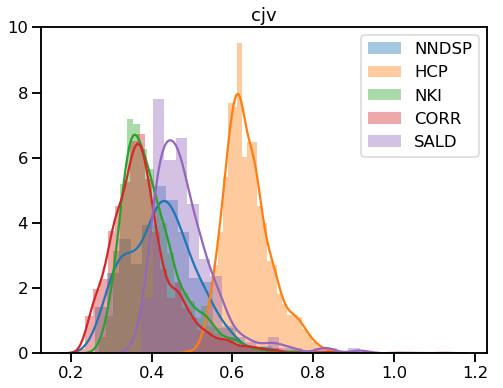

cnr 0.0


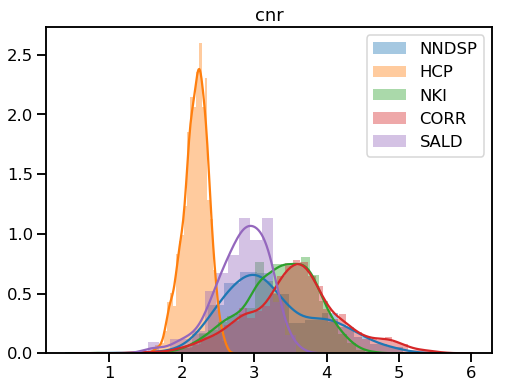

efc 0.0


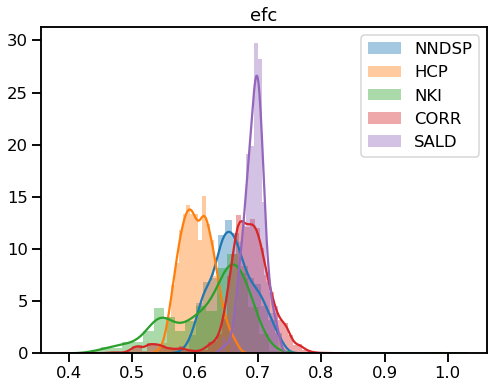

fber 0.0


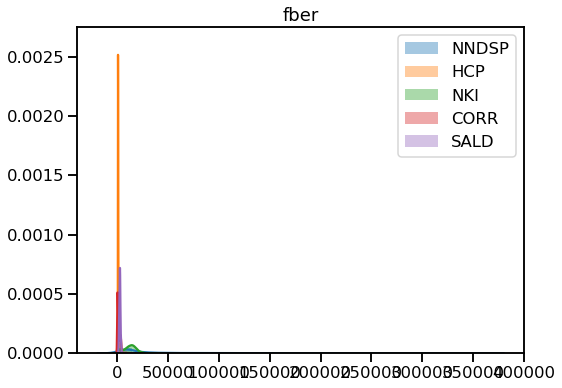

fwhm_avg 0.0


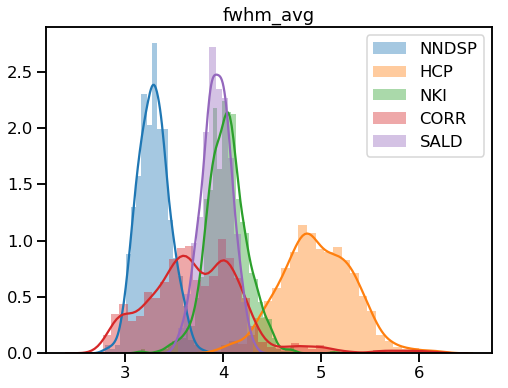

fwhm_x 0.0


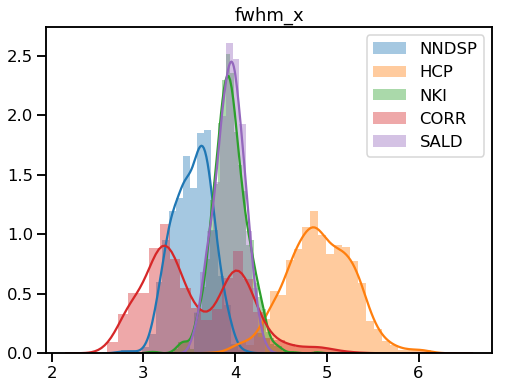

fwhm_y 0.0


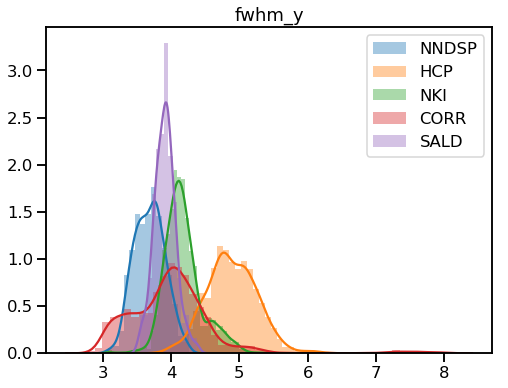

fwhm_z 0.0


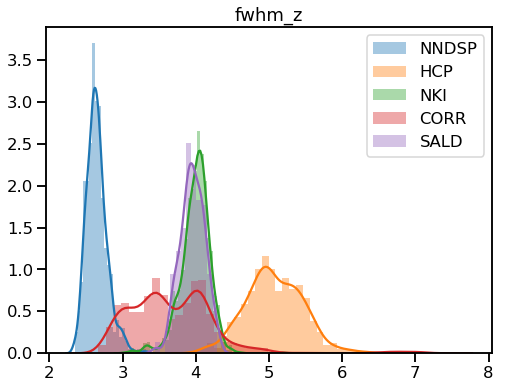

icvs_csf 0.0


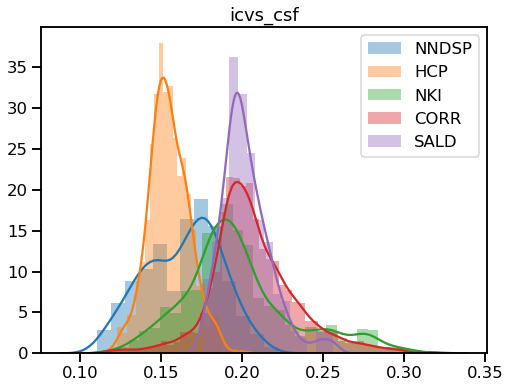

icvs_gm 0.0


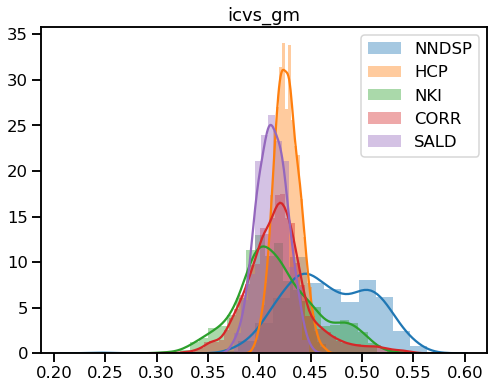

icvs_wm 0.0


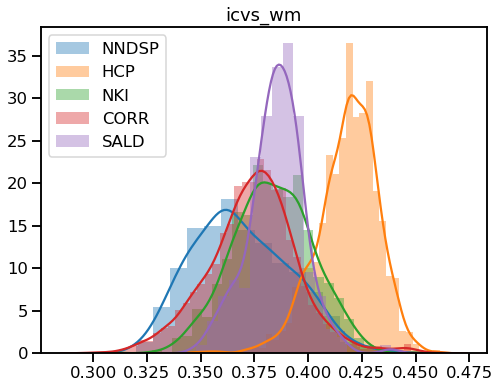

inu_med 0.0


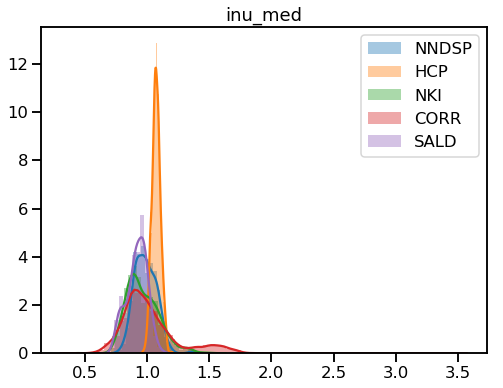

inu_range 0.0


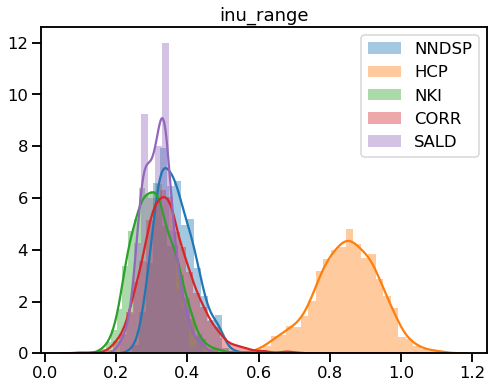

qi_1 0.0


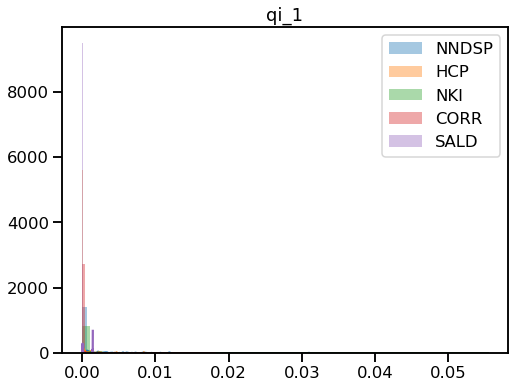

qi_2 0.0


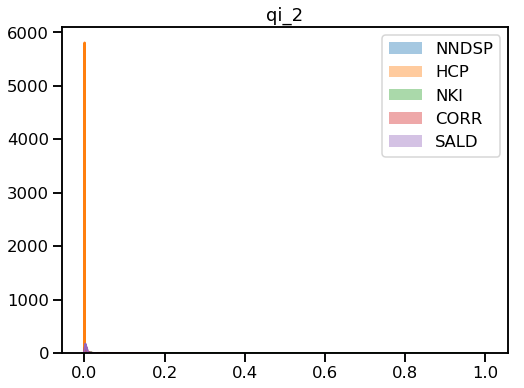

rpve_csf 0.0


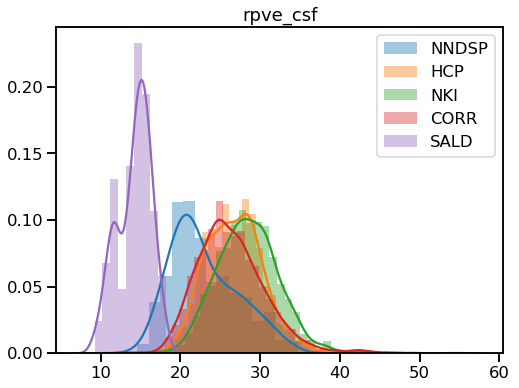

rpve_gm 0.0


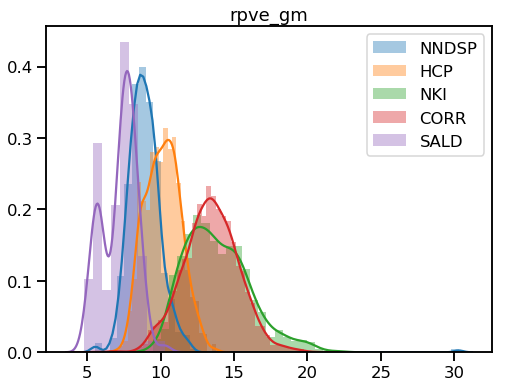

rpve_wm 0.0


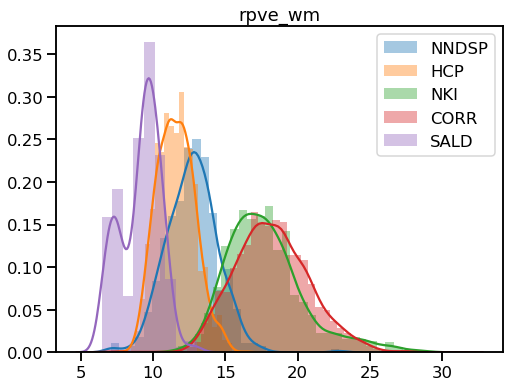

size_x 0.0


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


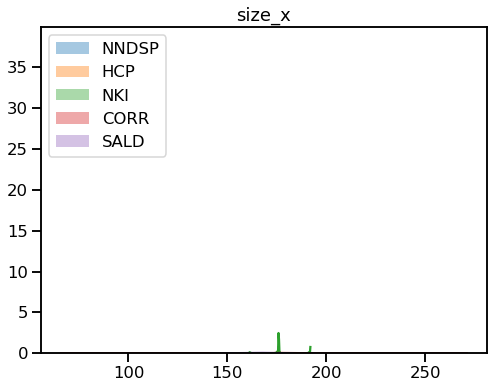

size_y 0.0


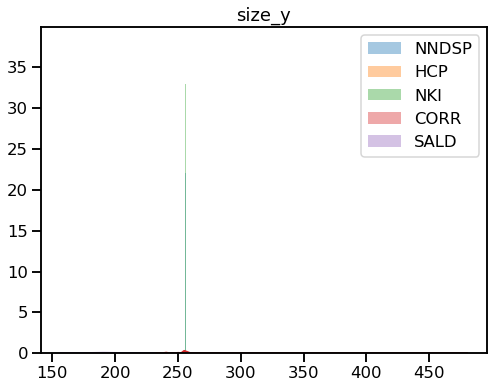

size_z 0.0


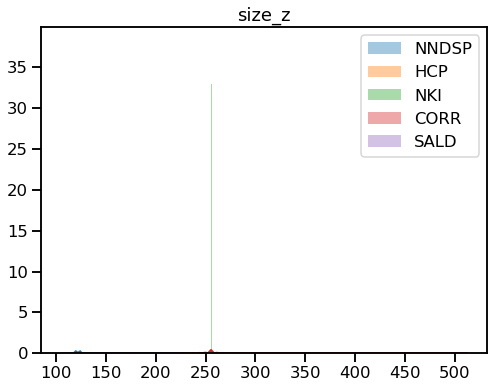

snr_csf 0.0


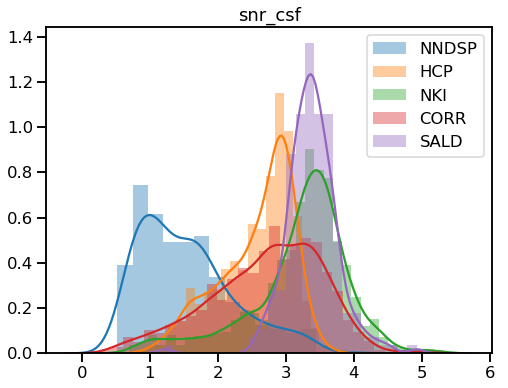

snr_gm 0.0


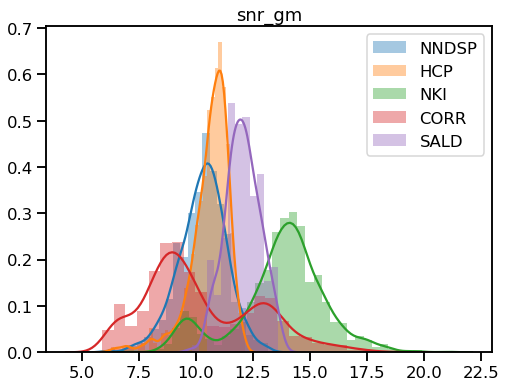

snr_total 0.0


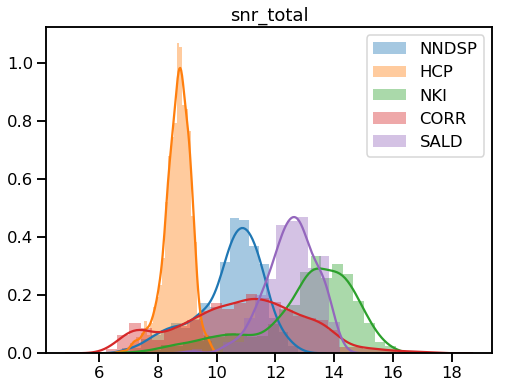

snr_wm 0.0


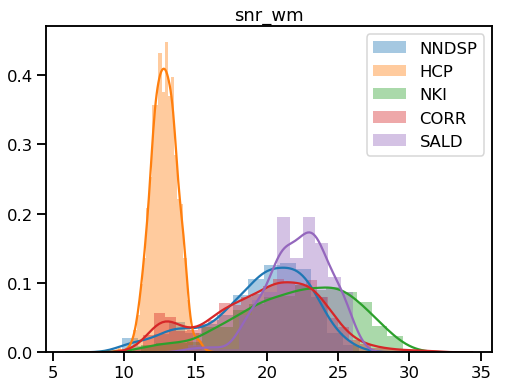

snrd_csf 0.0


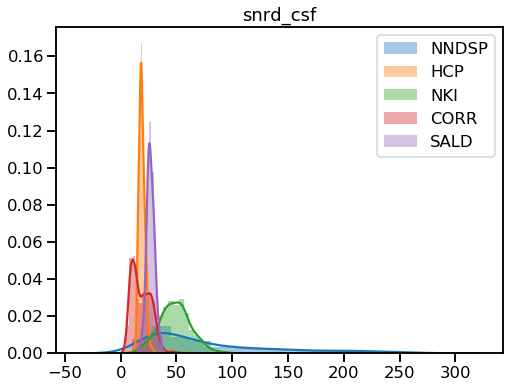

snrd_gm 0.0


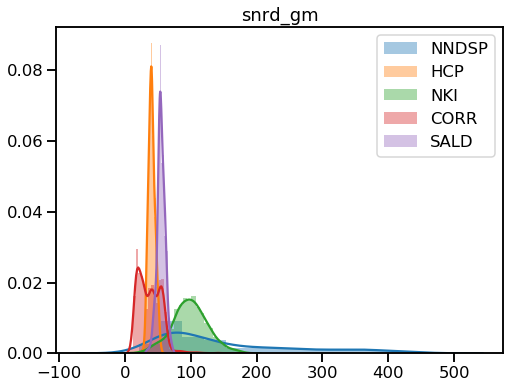

snrd_total 0.0


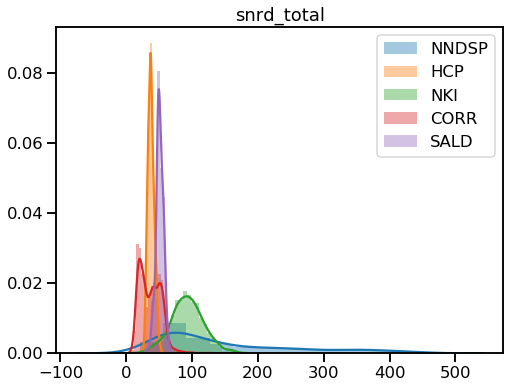

snrd_wm 0.0


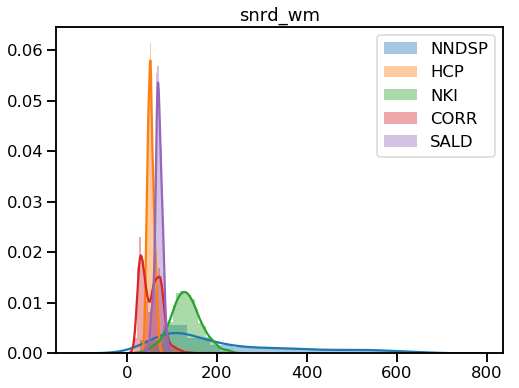

spacing_x 0.0


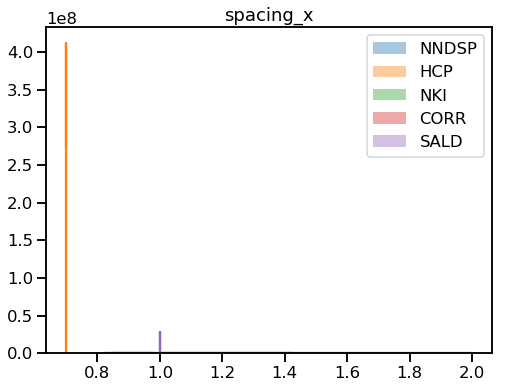

spacing_y 0.0


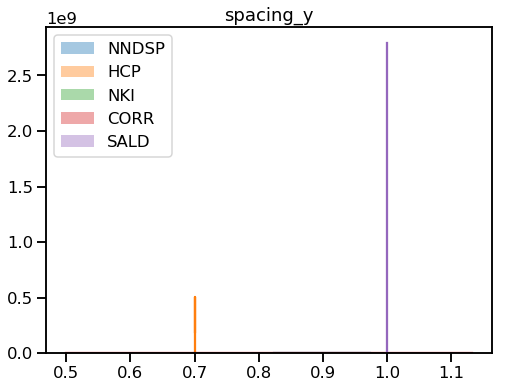

spacing_z 0.0


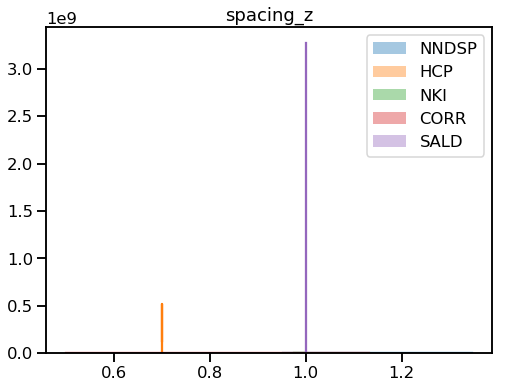

summary_bg_mad 0.0


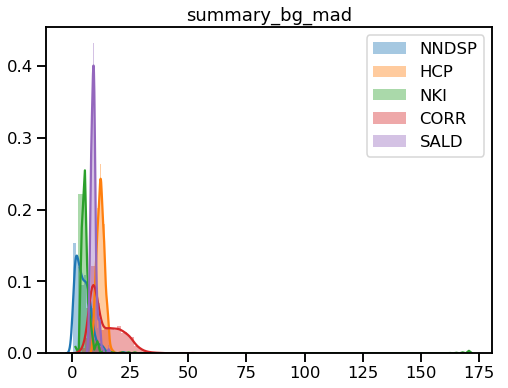

summary_bg_mean 0.0


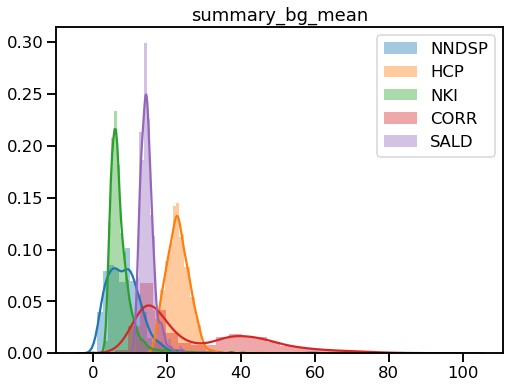

summary_bg_median 0.0


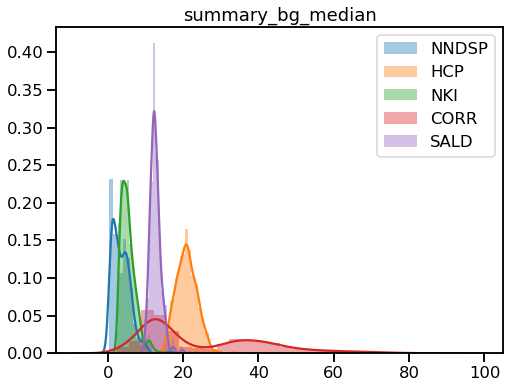

summary_bg_n 0.0


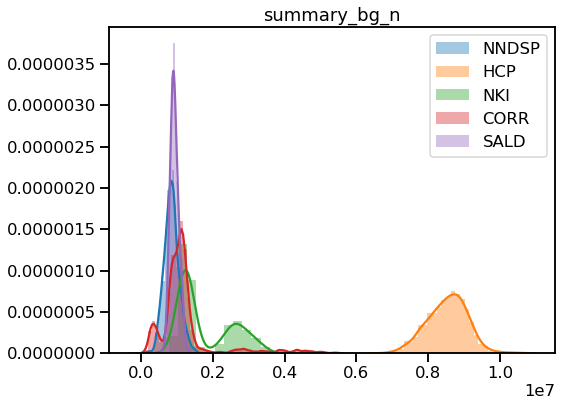

summary_bg_p05 0.0


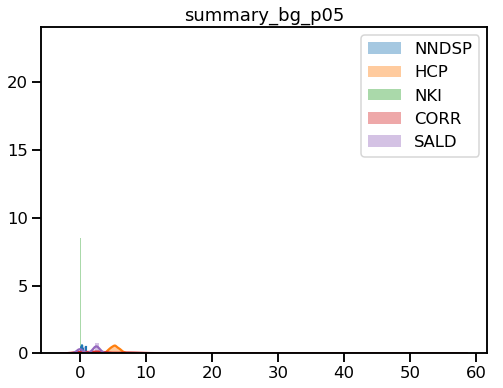

summary_bg_p95 0.0


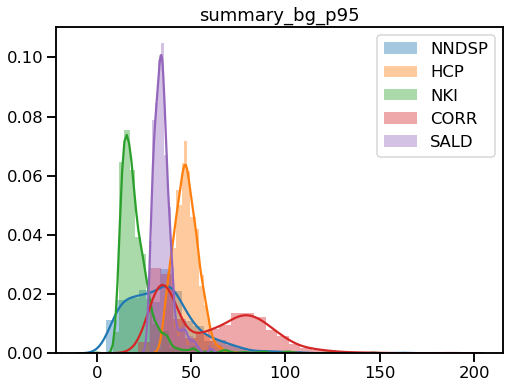

summary_bg_stdv 0.0


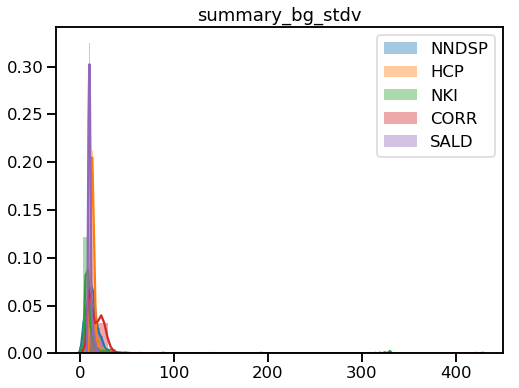

summary_csf_k 0.0


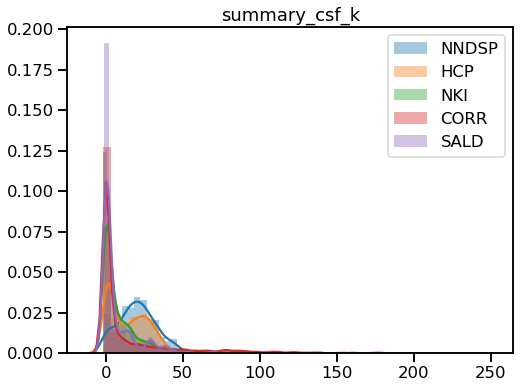

summary_csf_mad 0.0


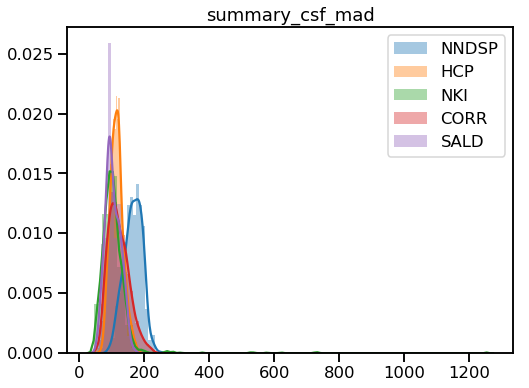

summary_csf_mean 0.0


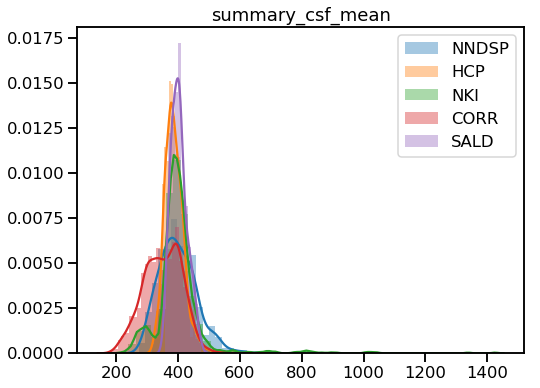

summary_csf_median 0.0


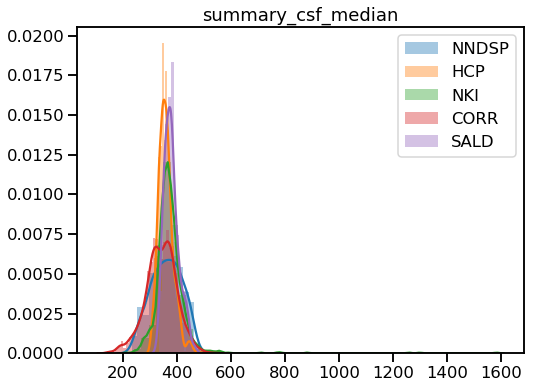

summary_csf_n 0.0


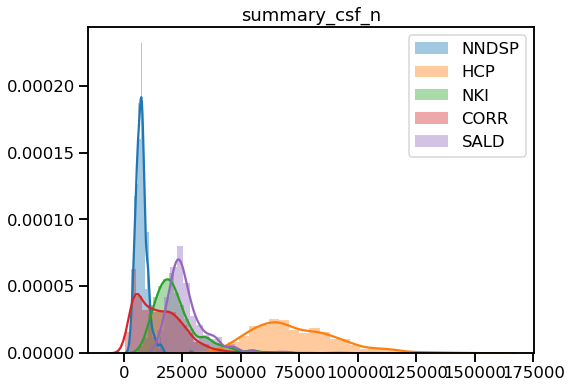

summary_csf_p05 0.0


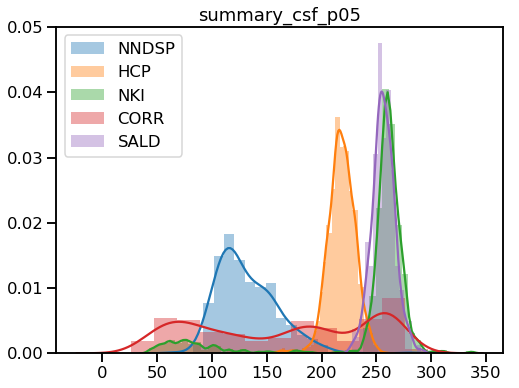

summary_csf_p95 0.0


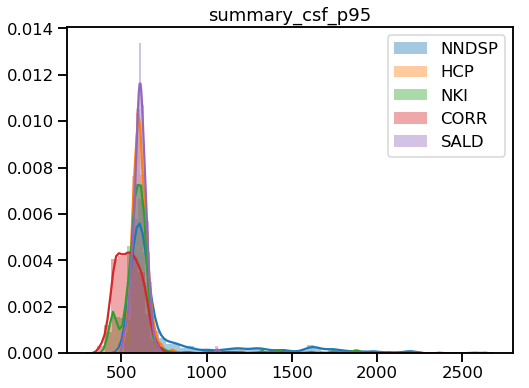

summary_csf_stdv 0.0


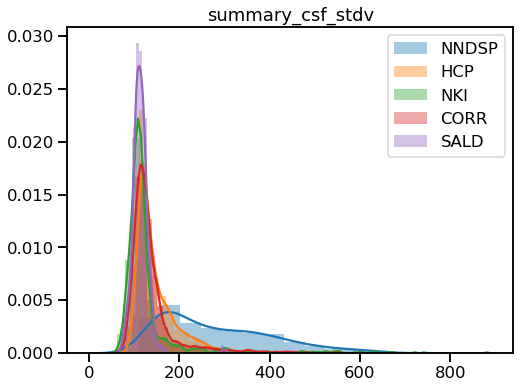

summary_gm_k 0.0


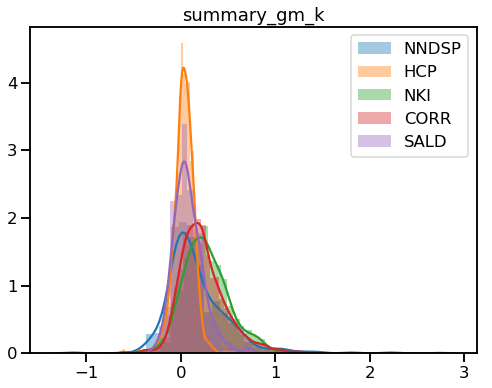

summary_gm_mad 0.0


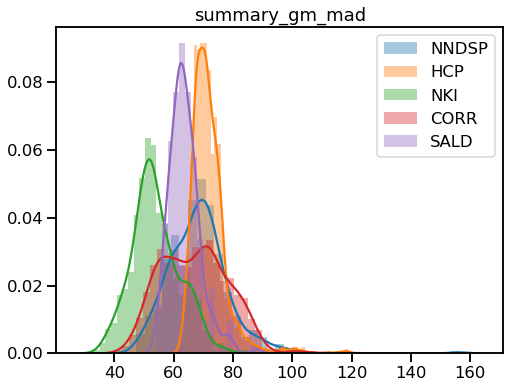

summary_gm_mean 0.0


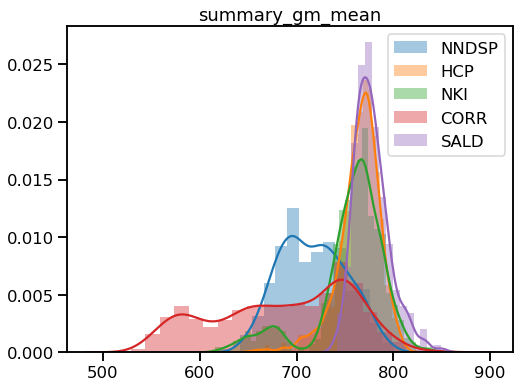

summary_gm_median 0.0


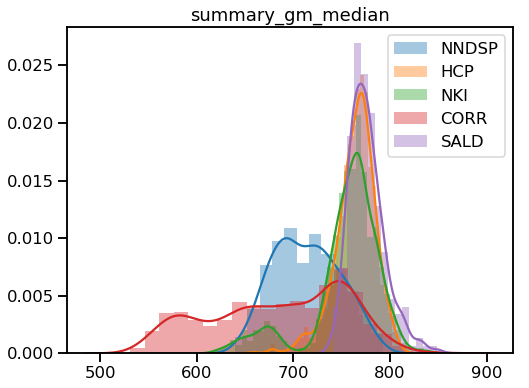

summary_gm_n 0.0


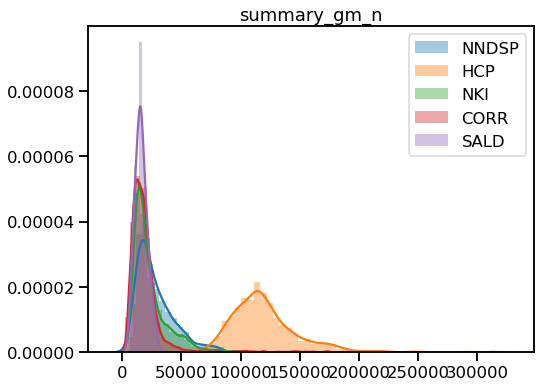

summary_gm_p05 0.0


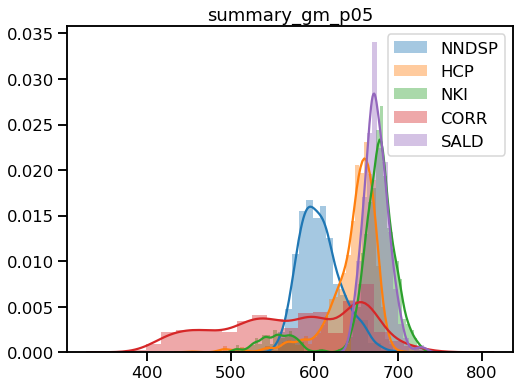

summary_gm_p95 0.0


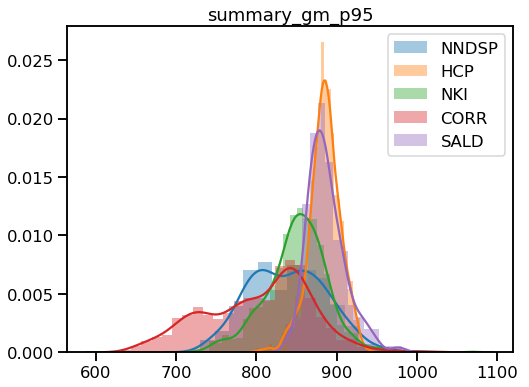

summary_gm_stdv 0.0


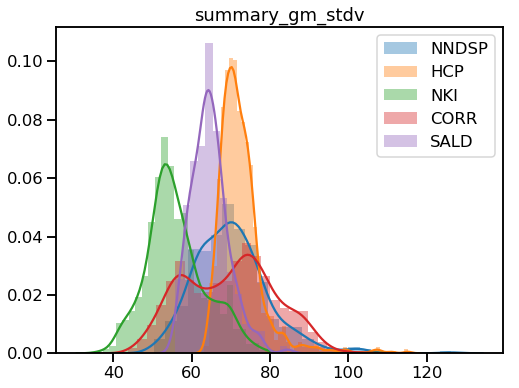

summary_wm_k 0.0


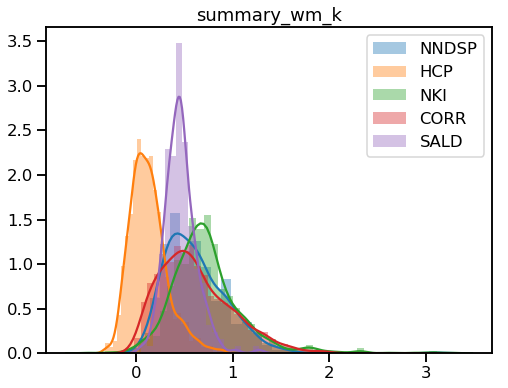

summary_wm_mad 0.0


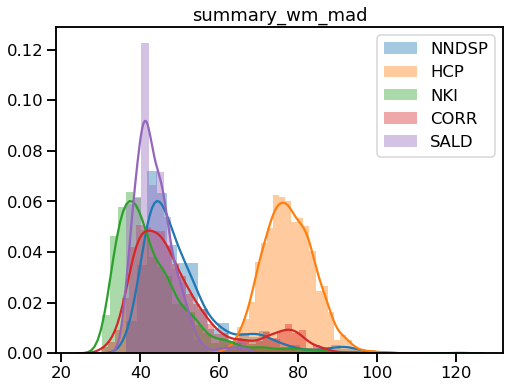

summary_wm_mean 0.0


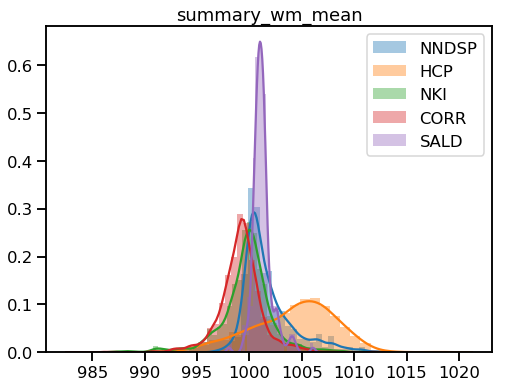

summary_wm_median 0.0


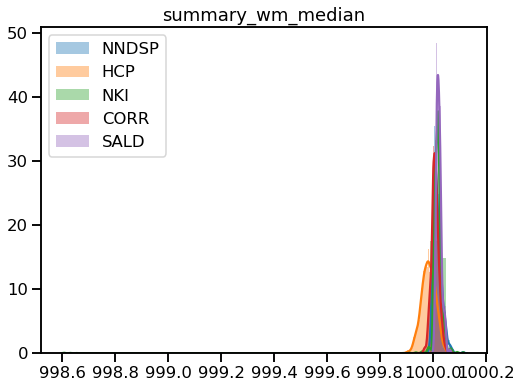

summary_wm_n 0.0


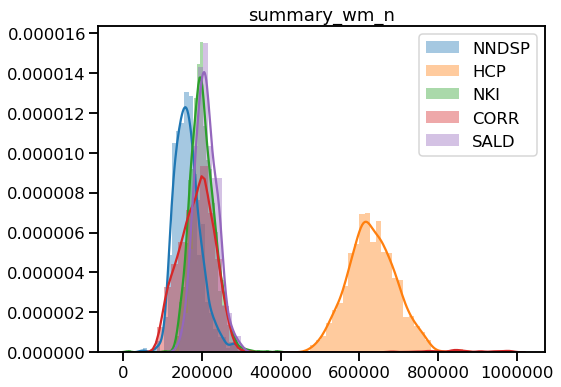

summary_wm_p05 0.0


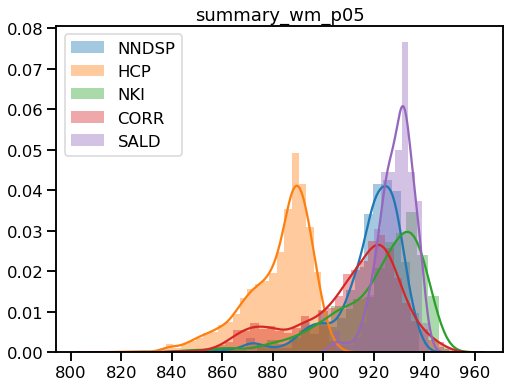

summary_wm_p95 0.0


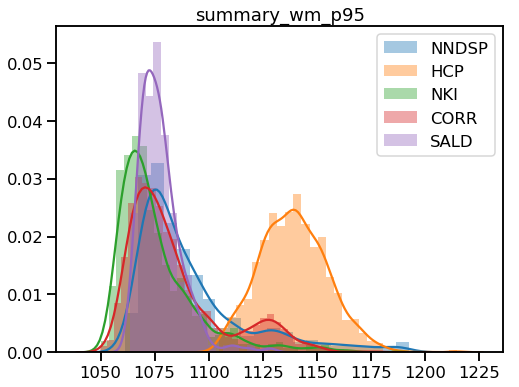

summary_wm_stdv 0.0


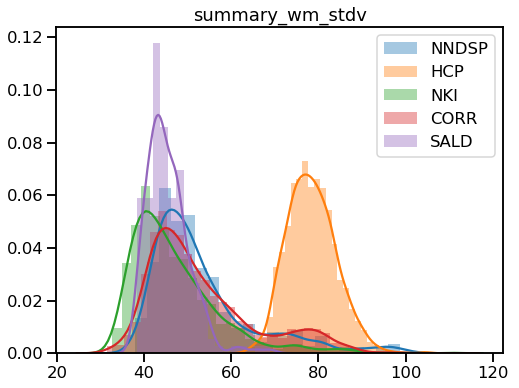

tpm_overlap_csf 0.0


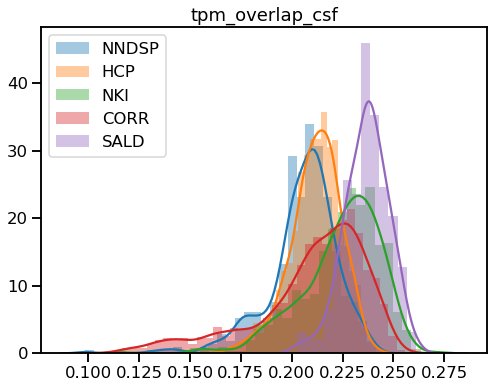

tpm_overlap_gm 0.0


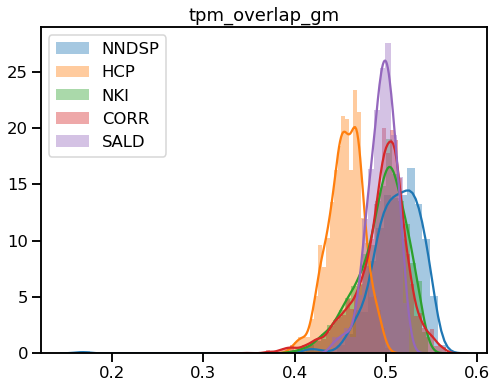

tpm_overlap_wm 0.0


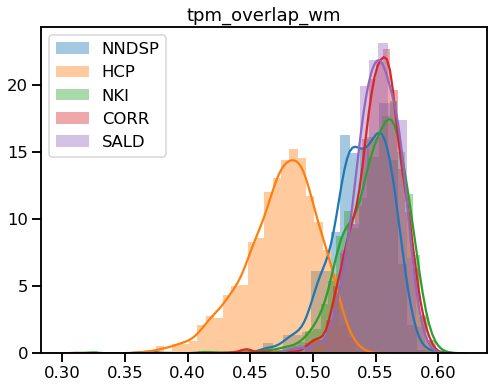

wm2max 0.0


In [ ]:
for i in range(0, len(p_val_corrected)):
    if p_val_corrected[i] <= 0.1:
        print(metrics[i], p_val_corrected[i])
        
        metric = metrics[i]
        plt.figure(figsize=(8,6))
        for data_class in df_all.data_class.drop_duplicates():
            sns.set_context('talk')
            sns.distplot(df_all[df_all.data_class == data_class][metric].dropna(),
                         label=dataset_mapping[str(data_class)].upper(), )
        
        plt.title(metric)
        plt.xlabel('')
        plt.legend(loc='best')
        plt.savefig('/data/NNDSP/anal/analysis_notebooks/follow_up_analysis/figures/h2.3_'+metric+'.png', dpi=300)
        plt.show()

## Post Hoc Tests (Tukey Kramer Test)

In [19]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_stats.ipynb

In [20]:
import math

df_gh = pd.DataFrame([])
for metric in metrics:
    pairs = []
    p_vals = []
    
    dataset_first = [x for x in df_all.data_class.drop_duplicates()]
    dataset_second = dataset_first.copy()
    
    for data_first in dataset_first:
        dataset_second.remove(data_first)
        
        for data_second in dataset_second:
            group_first = df_all[df_all.data_class == data_first][metric].dropna().tolist()
            group_second = df_all[df_all.data_class == data_second][metric].dropna().tolist()

            pairs.append(dataset_mapping[str(data_first)] + ':' + dataset_mapping[str(data_second)])
            p_vals.append(games_howell(group_first, group_second)[0])
    
    df_gh['pairs'] = pairs
    df_gh[metric] = p_vals

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [21]:
df_gh

pairs           cjv           cnr           efc      fber  \
0   nndsp:hcp  4.320704e-10  8.663792e-11  4.505867e-10  0.999679   
1   nndsp:nki  0.000000e+00  3.626736e-06  0.000000e+00  0.999801   
2  nndsp:corr  0.000000e+00  0.000000e+00  1.098011e-13  0.999686   
3  nndsp:sald  0.000000e+00  0.000000e+00  4.923619e-10  0.999697   
4     hcp:nki  7.158274e-12  0.000000e+00  2.086109e-13  0.991184   
5    hcp:corr  4.357965e-08  0.000000e+00  2.369070e-08  0.988911   
6    hcp:sald  7.638334e-14  0.000000e+00  0.000000e+00  0.937001   
7    nki:corr  0.000000e+00  1.989748e-09  0.000000e+00  0.991712   
8    nki:sald  1.570966e-13  3.399383e-10  0.000000e+00  0.992537   
9   corr:sald  9.447998e-14  4.641048e-10  0.000000e+00  0.983816   

       fwhm_avg        fwhm_x        fwhm_y        fwhm_z      icvs_csf  \
0  2.993272e-12  3.369505e-11  3.099787e-11  0.000000e+00  2.004561e-10   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  3.471237e-08  1.529944e-09  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  1.084688e-12  0.000000e+00   
4  1.060163e-11  3.228751e-12  0.000000e+00  3.420819e-12  6.232792e-13   
5  4.355459e-08  4.338808e-08  3.228158e-08  4.334558e-08  9.102576e-09   
6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  4.130030e-14   
7  1.696507e-09  0.000000e+00  4.338190e-09  0.000000e+00  0.000000e+00   
8  4.100603e-10  6.336261e-02  0.000000e+00  0.000000e+00  0.000000e+00   
9  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  4.159534e-10   

       ...       summary_wm_mean  summary_wm_median  summary_wm_n  \
0      ...          5.111858e-07       2.673695e-11      0.996597   
1      ...          1.297133e-09       4.264073e-05      0.999494   
2      ...          4.904195e-10       4.819493e-10      0.999846   
3      ...          4.767768e-02       0.000000e+00      0.999497   
4      ...          4.967915e-11       0.000000e+00      0.996624   
5      ...          0.000000e+00       0.000000e+00      0.998138   
6      ...          1.871836e-13       1.500466e-12      0.996959   
7      ...          6.105088e-03       0.000000e+00      0.999972   
8      ...          5.210277e-13       1.374456e-13      0.999888   
9      ...          0.000000e+00       0.000000e+00      0.999932   

   summary_wm_p05  summary_wm_p95  summary_wm_stdv  tpm_overlap_csf  \
0    4.236858e-04    1.202857e-01     1.804732e-04     5.063813e-10   
1    7.885393e-01    6.259423e-01     3.866664e-01     1.033618e-13   
2    5.263128e-01    8.152749e-01     9.648566e-01     1.398437e-12   
3    2.412226e-01    6.476299e-01     2.486391e-01     0.000000e+00   
4    4.479212e-04    3.836875e-07     0.000000e+00     0.000000e+00   
5    1.342604e-03    7.797601e-07     5.798444e-09     5.987625e-09   
6    8.729684e-13    0.000000e+00     1.042721e-12     1.210143e-14   
7    3.827596e-01    5.557348e-01     1.456381e-01     1.559407e-08   
8    4.811828e-01    9.052857e-01     6.583503e-01     8.117951e-13   
9    2.298198e-02    5.455680e-01     1.815902e-02     6.108780e-11   

   tpm_overlap_gm  tpm_overlap_wm        wm2max  
0    4.002757e-10    0.000000e+00  6.941114e-13  
1    0.000000e+00    2.764455e-14  0.000000e+00  
2    0.000000e+00    5.059417e-10  0.000000e+00  
3    3.847433e-11    0.000000e+00  0.000000e+00  
4    0.000000e+00    0.000000e+00  0.000000e+00  
5    4.362215e-08    1.037015e-11  6.562197e-10  
6    0.000000e+00    0.000000e+00  1.850742e-13  
7    0.000000e+00    0.000000e+00  1.030703e-09  
8    2.409184e-14    0.000000e+00  0.000000e+00  
9    0.000000e+00    4.359846e-13  0.000000e+00  

[10 rows x 68 columns]

In [46]:
all_sig_pvals = []
for col in df_gh.columns:
    if col != 'pairs':
        for val in df_gh[col].values:
            if val <= 0.05:
                all_sig_pvals.append(val)
max(all_sig_pvals)

0.04767767770907294

In [22]:
%store df_gh
%store metrics

Stored 'df_gh' (DataFrame)
Stored 'metrics' (list)


In [42]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]
cm = sns.light_palette("green", as_cmap=True)

# (df_gh[['cjv', 'cnr', 'efc', 'fber']].style
#   .background_gradient(cmap=cm, subset=['cjv','cnr'])
#   .highlight_max(subset=['cjv','cnr'])
#   .set_table_styles(styles))

important_metrics = (['cjv', 'efc','rpve_csf', 'rpve_gm', 'rpve_wm'] +
            ['cnr', 'snr_csf', 'snr_gm', 'snr_total', 'fber'] +
          ['inu_med'])
df_gh[important_metrics].style.apply(lambda x: ["background: rgba(0,200,0, 0.5)" if v < 0.05 else "background: rgba(200,0,0, 0.5)" for v in x], axis = 1)

## Visualizing QC Metrics

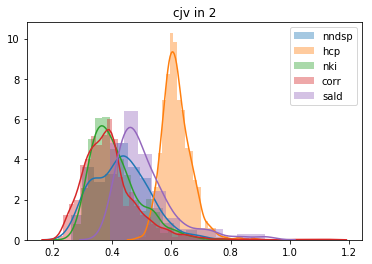

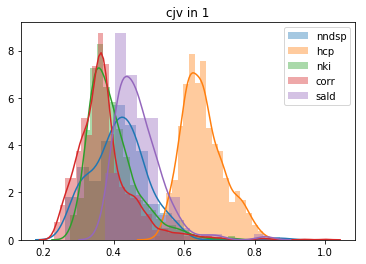

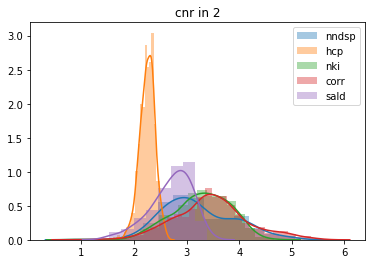

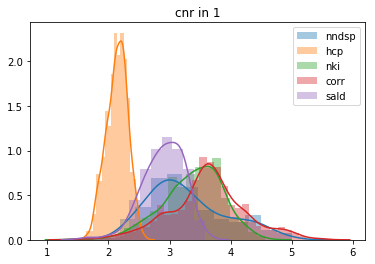

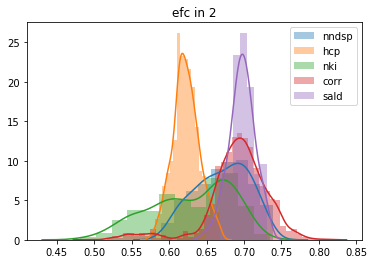

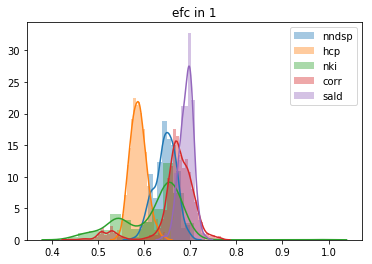

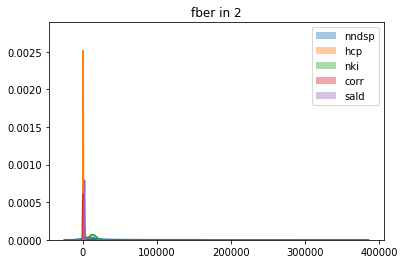

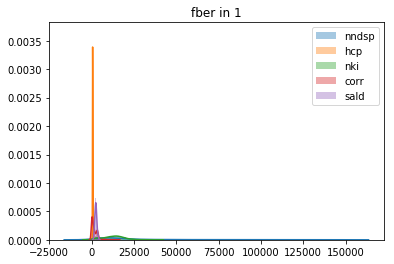

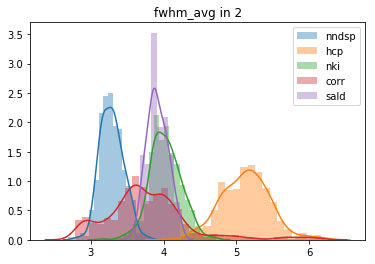

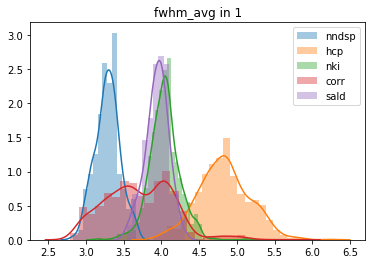

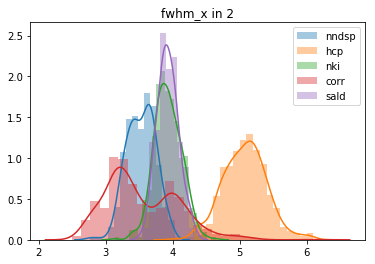

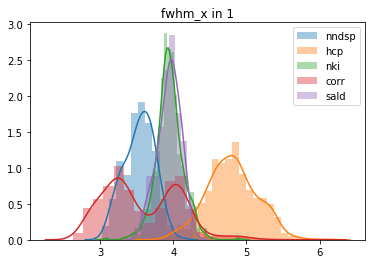

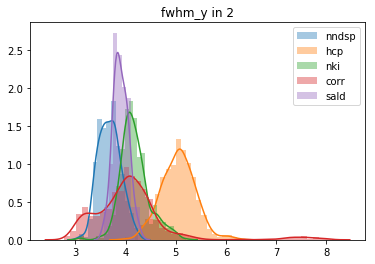

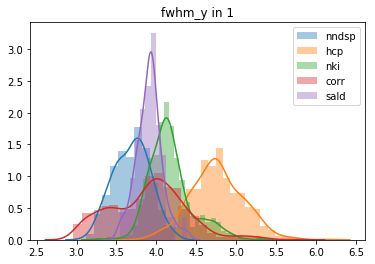

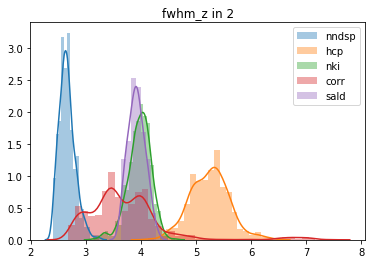

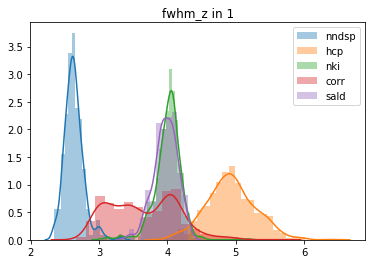

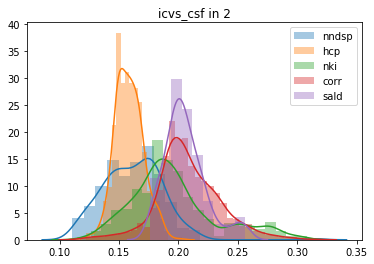

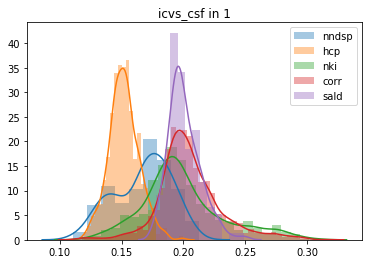

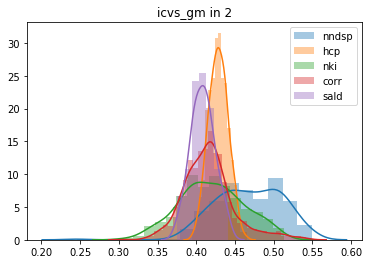

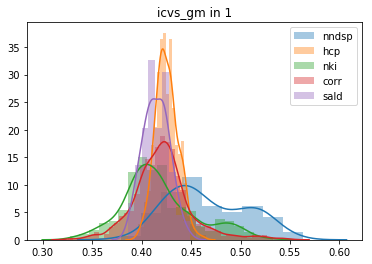

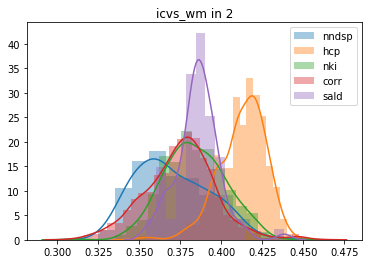

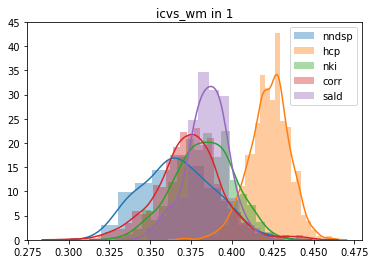

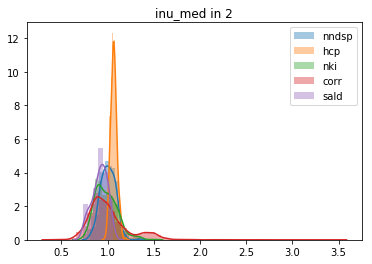

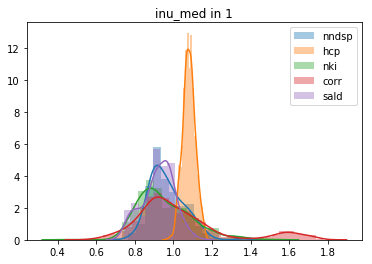

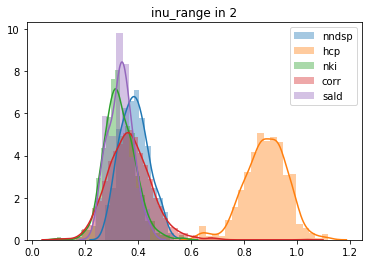

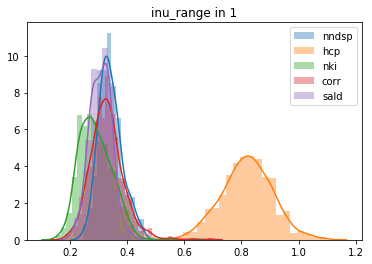

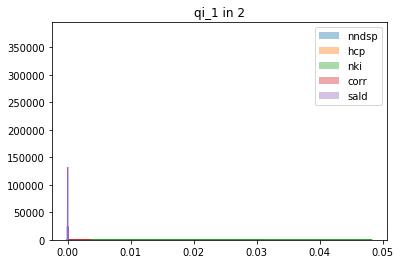

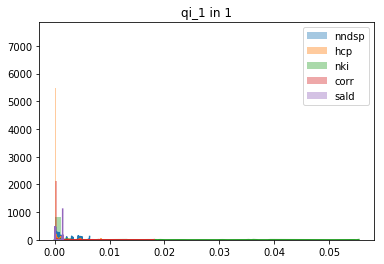

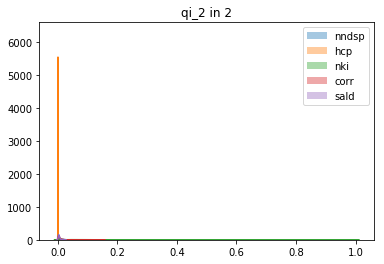

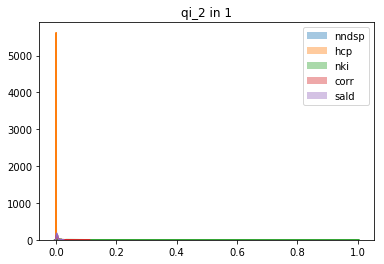

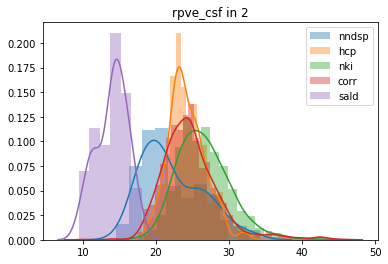

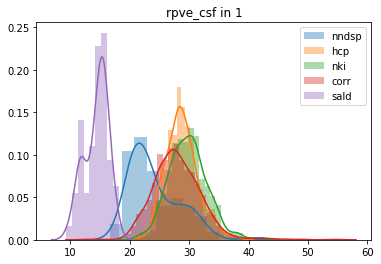

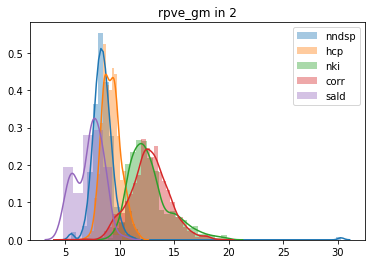

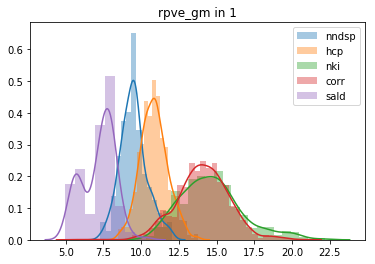

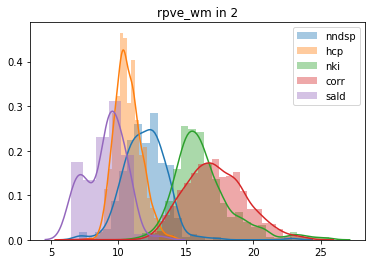

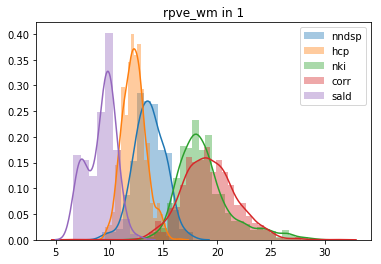

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


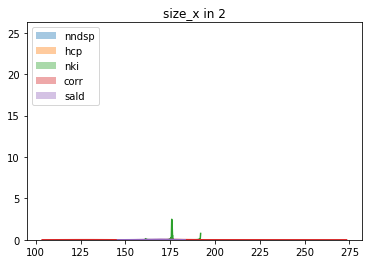

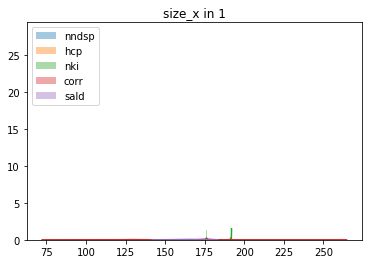

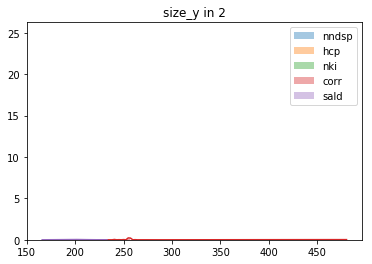

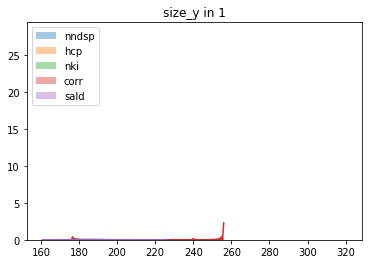

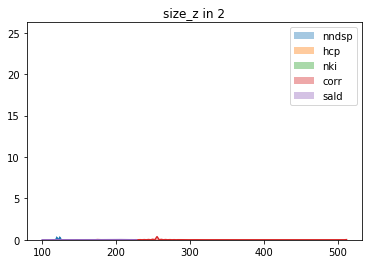

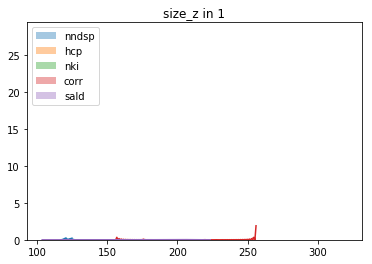

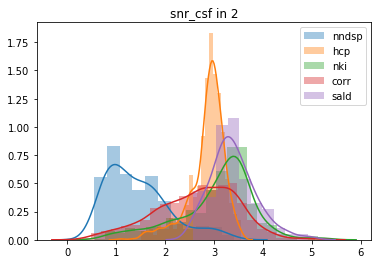

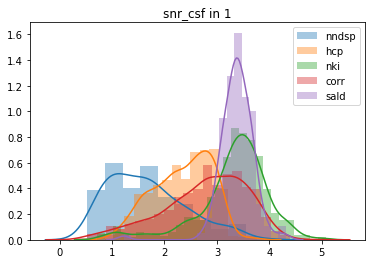

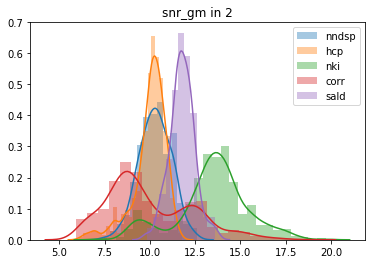

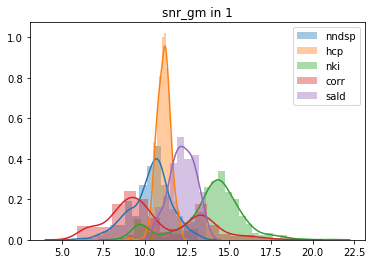

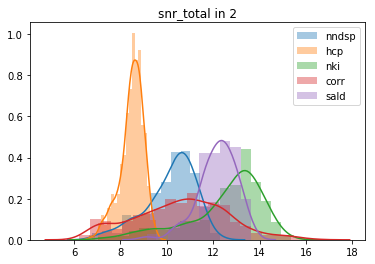

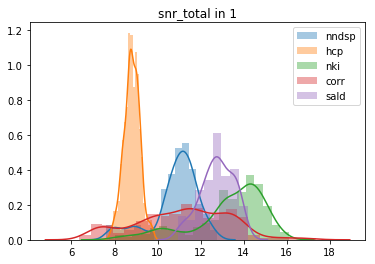

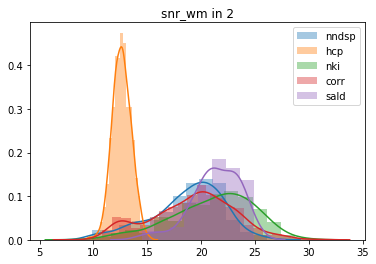

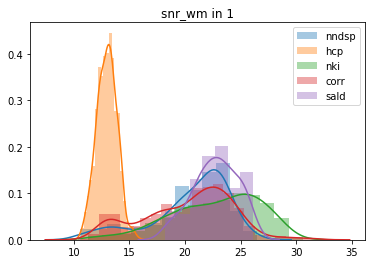

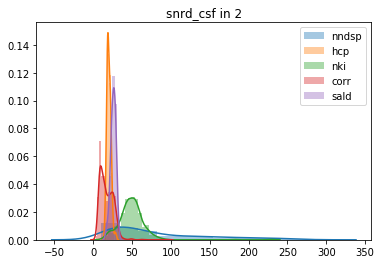

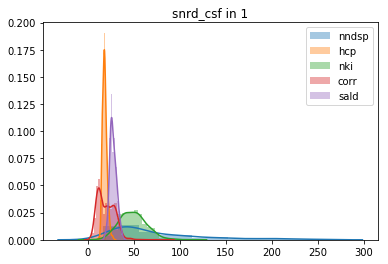

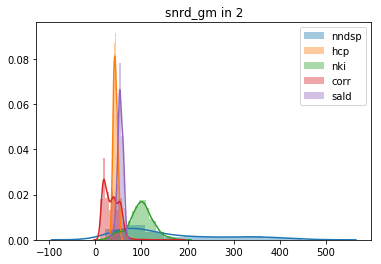

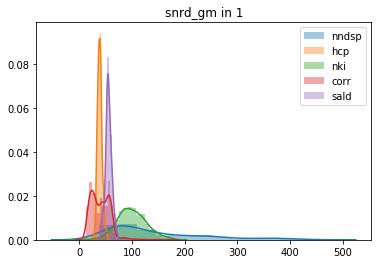

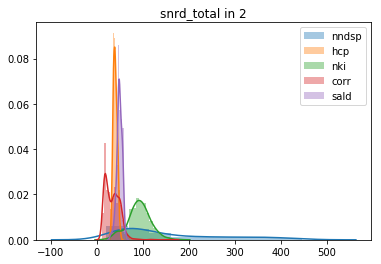

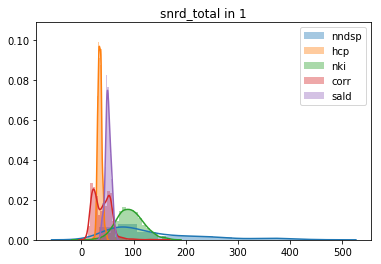

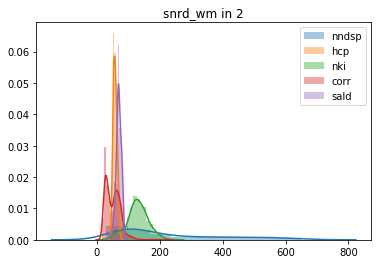

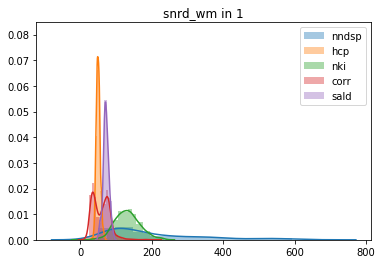

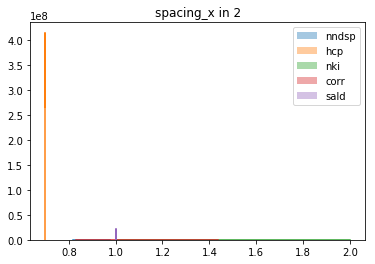

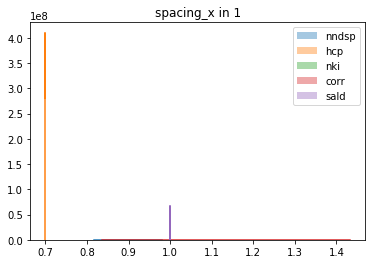

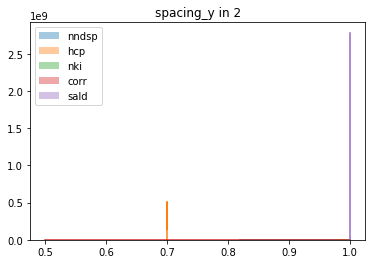

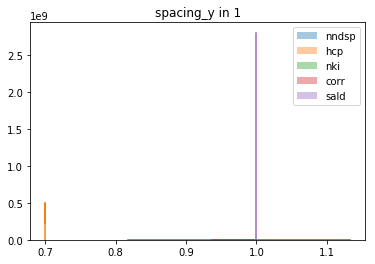

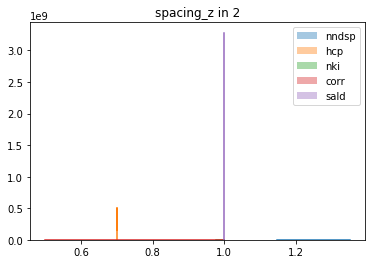

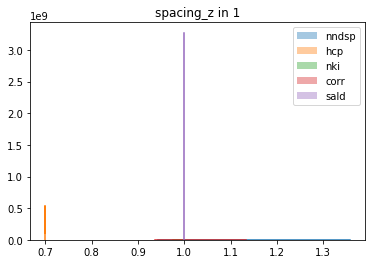

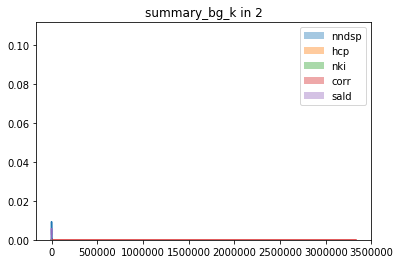

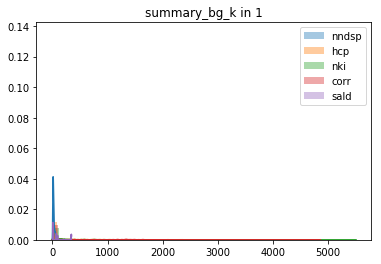

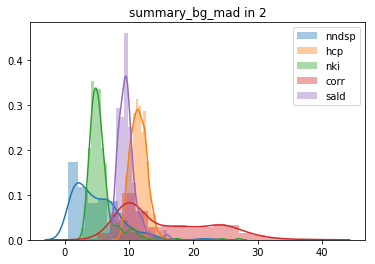

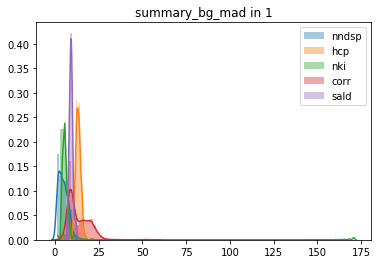

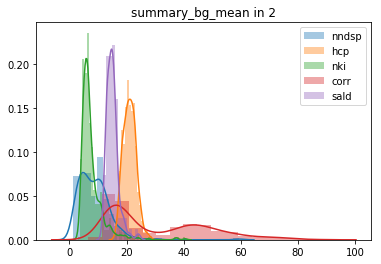

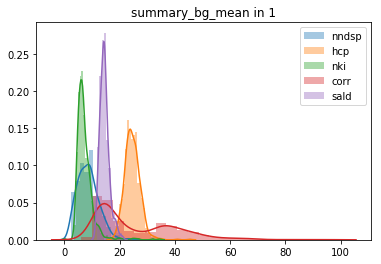

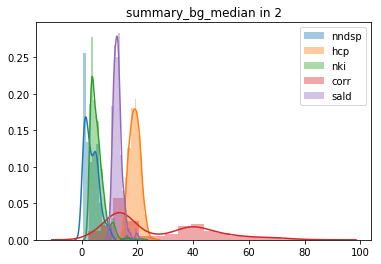

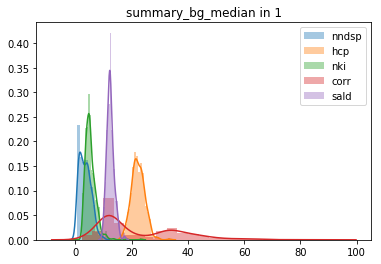

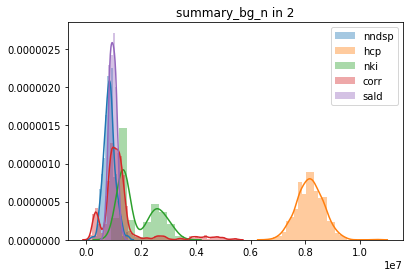

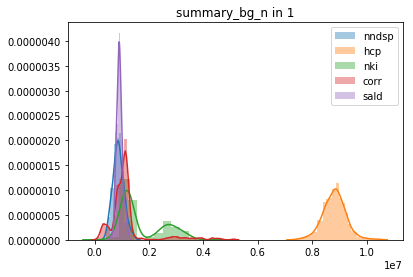

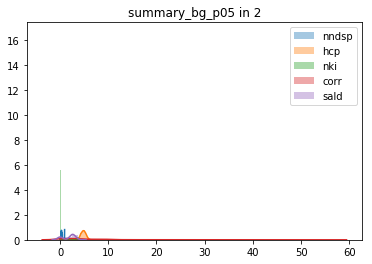

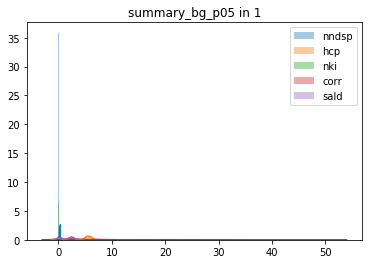

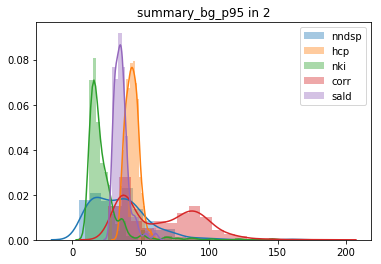

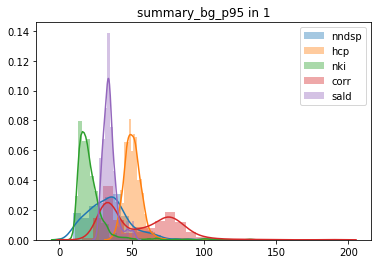

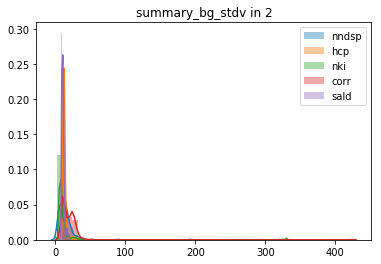

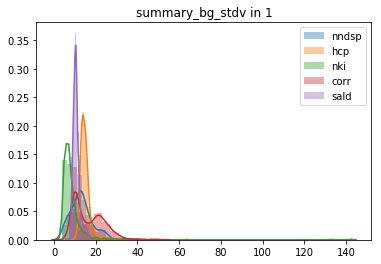

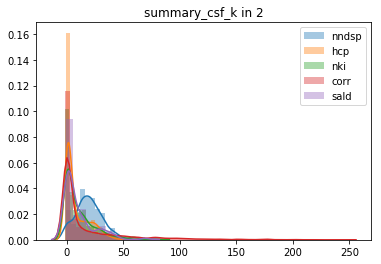

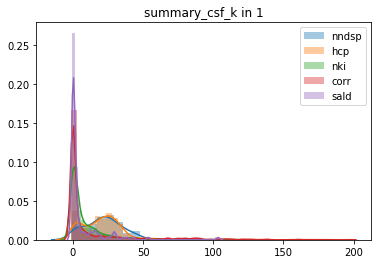

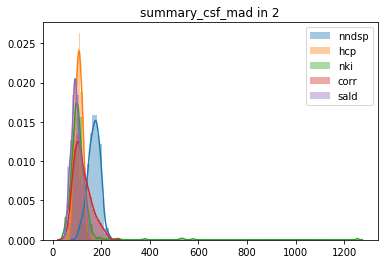

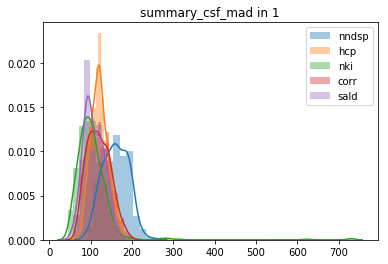

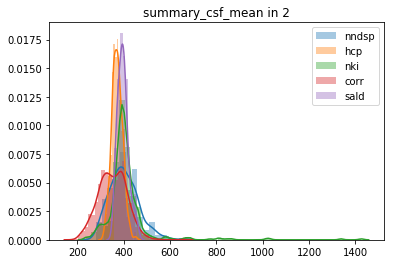

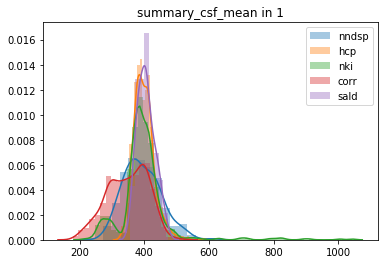

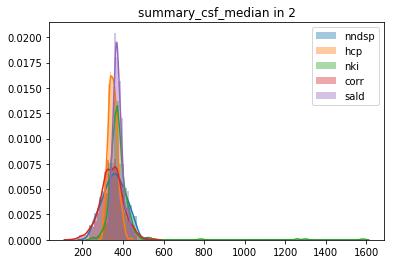

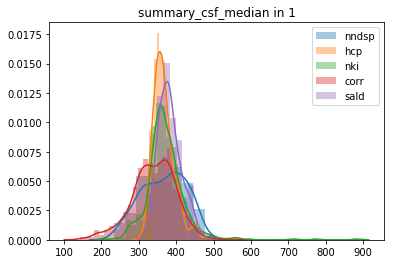

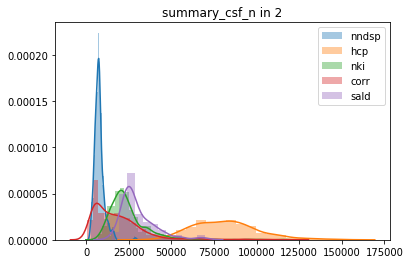

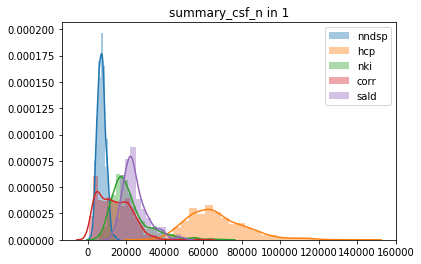

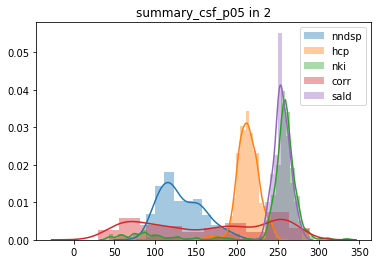

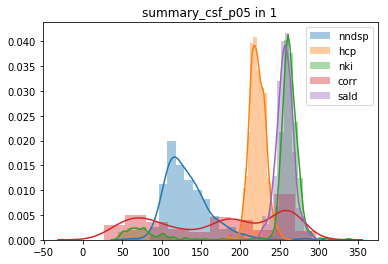

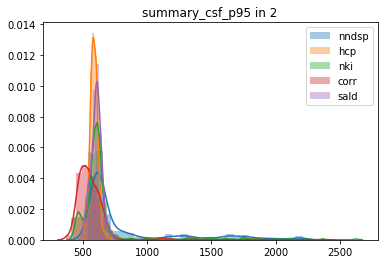

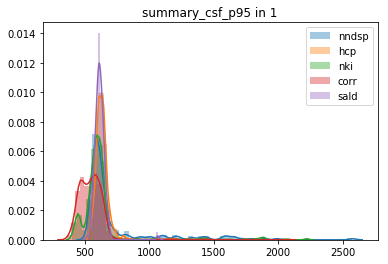

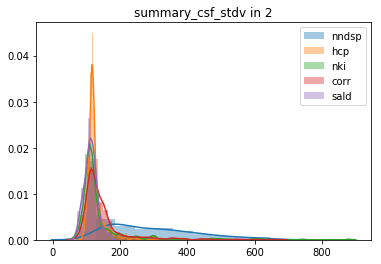

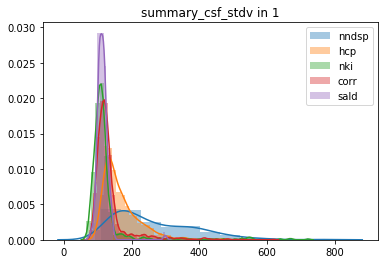

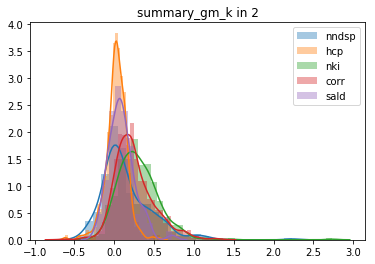

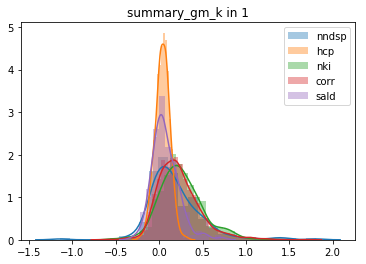

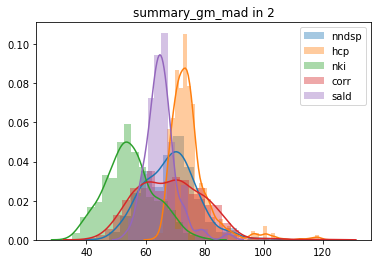

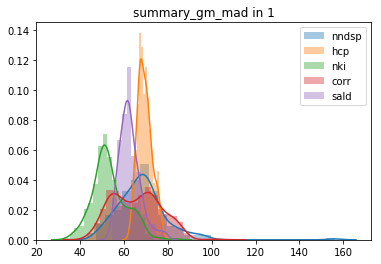

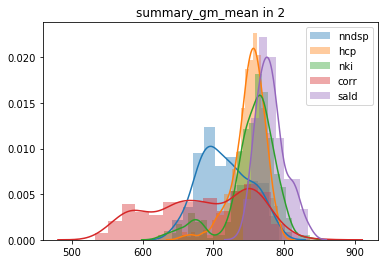

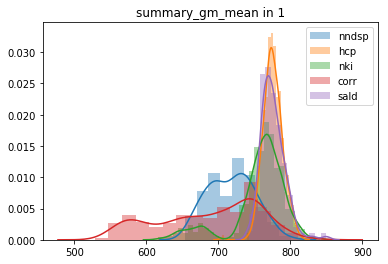

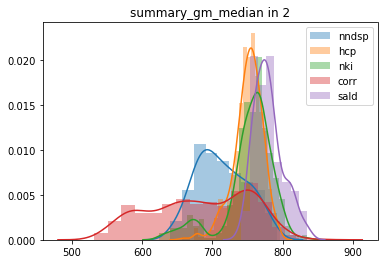

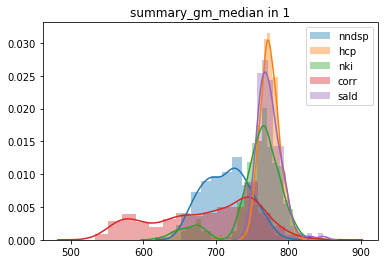

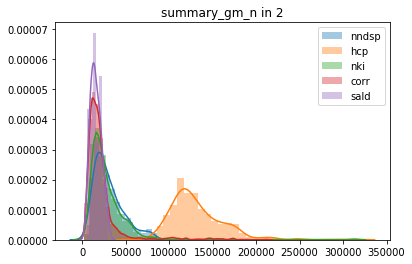

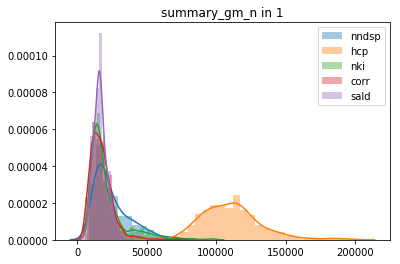

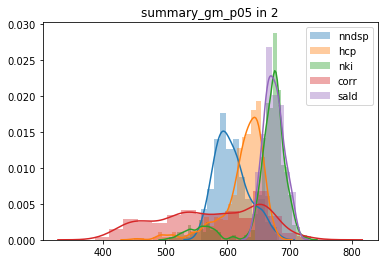

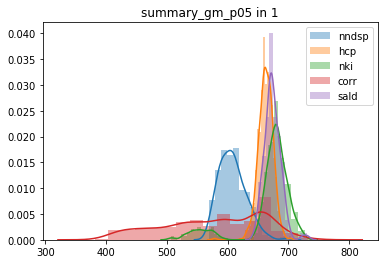

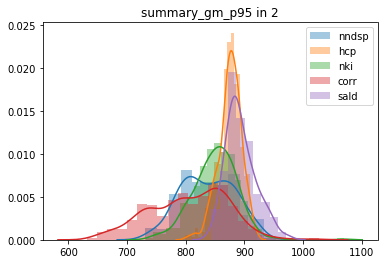

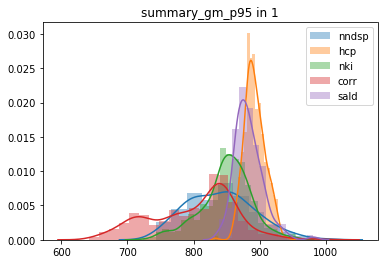

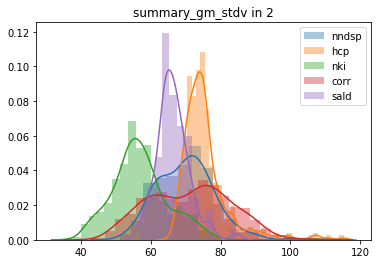

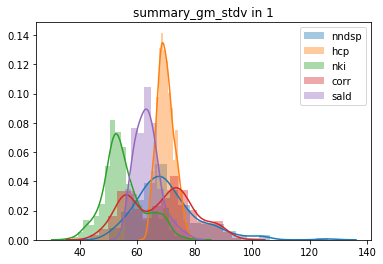

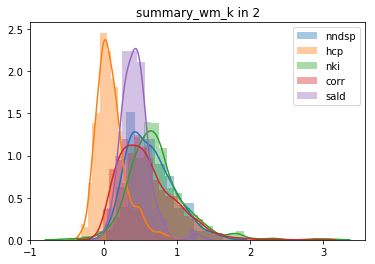

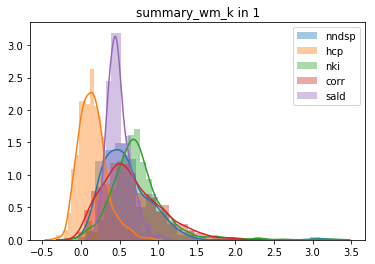

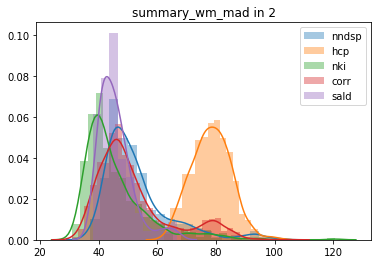

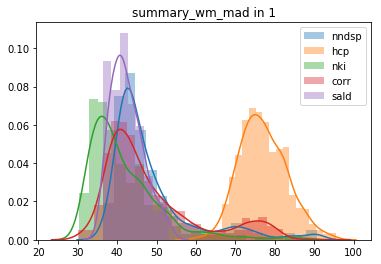

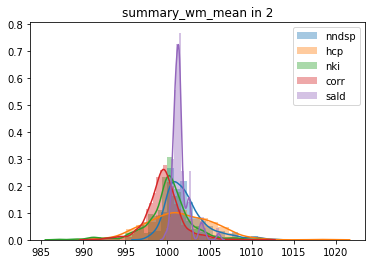

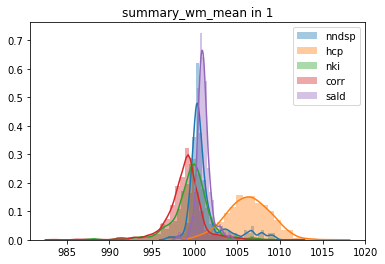

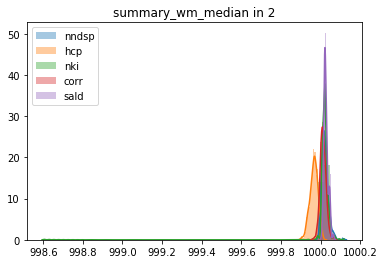

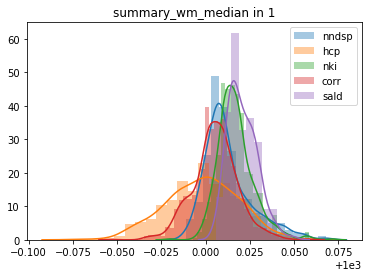

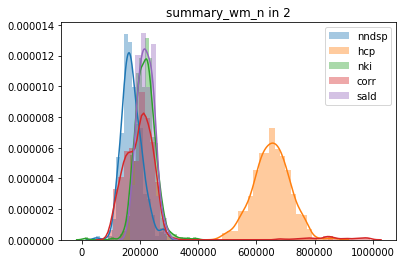

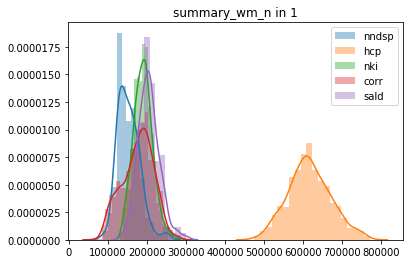

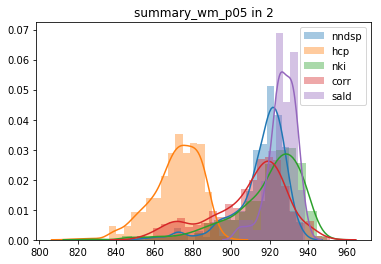

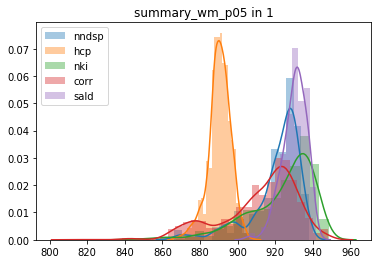

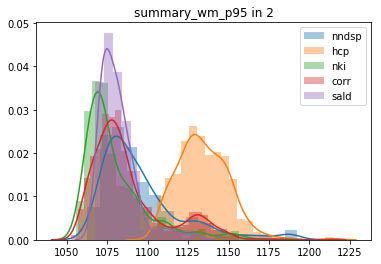

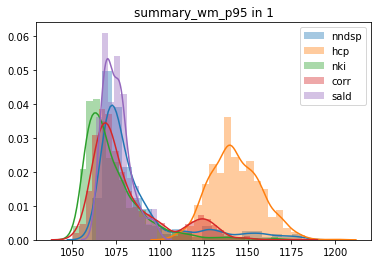

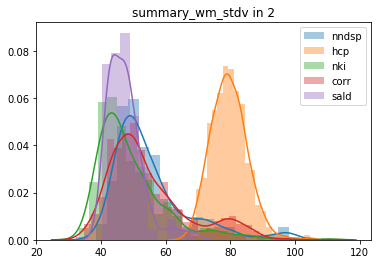

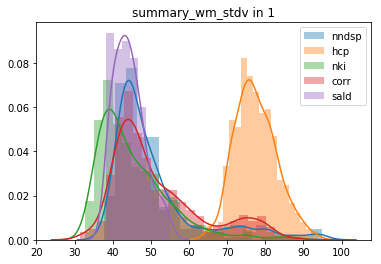

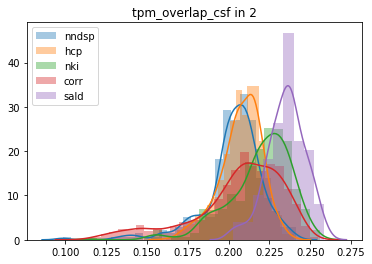

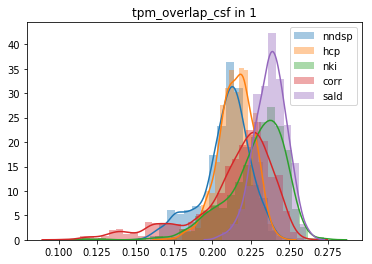

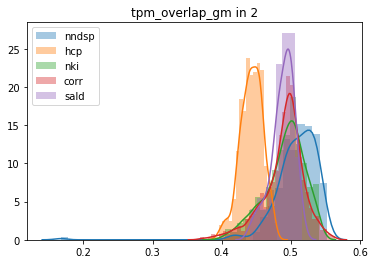

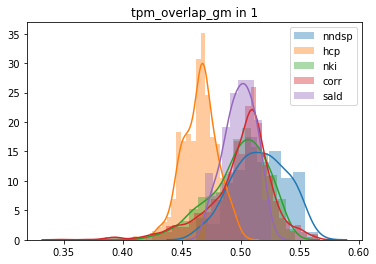

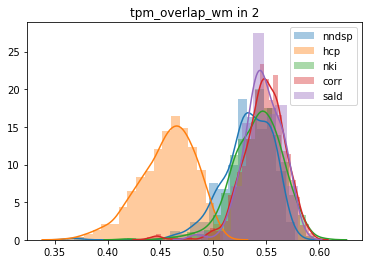

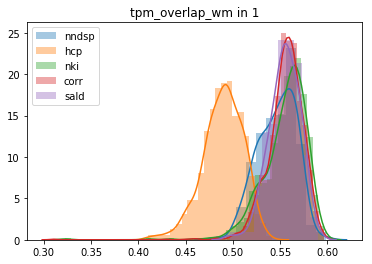

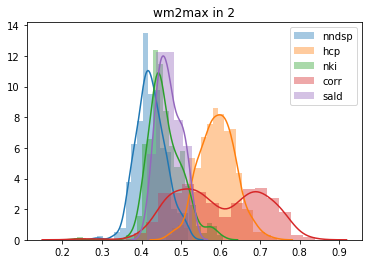

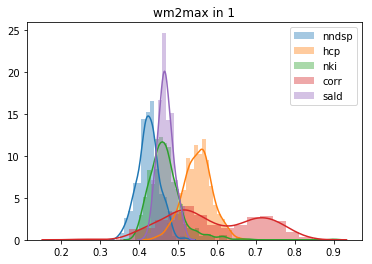

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

for qc_metric in qc_metrics:
    for sex in df_all.sex.drop_duplicates():
        for data_class in df_all.data_class.drop_duplicates():
            sns.distplot(df_all.query('data_class == ' + str(data_class) + ' and sex == ' + str(sex))[qc_metric].dropna(), 
                         label=dataset_mapping[str(data_class)])
    
        plt.title(qc_metric + ' in ' + str(sex))
        plt.xlabel('')
        plt.legend(loc='best')
        plt.show()        